# __포스트 코로나 시대, 🛵 배달 음식점 가보자고! 🍚🍗🍕🥤🍔__
### - 코로나와 생활인구 데이터로 알아보는 소상공인 배달 가이드 -
  

#### **목차**
* __서론__  

* __본론__  
  1. 데이터 전처리
  2. 간단한 데이터 시각화
  3. 코로나 확진자와 배달건수
  4. 서울시 시간대별 생활인구 및 배달건수-사회적 거리두기 중심으로
  5. 날씨, 코로나, 배달접수요일이 배달건수에 영향을 주는지
  6. 분석결과 및 한계점
 
* __결론__   
 

#### **사용 데이터 목록**
* dlvr_call.csv (배달호출데이터)
* popl.csv (행정동별 생활인구 데이터)
* StartupOrClosing_Region_ver2.csv (업종/ 상호별 창업, 폐업 유추 데이터)
* Time.csv (코로나 데이터)
* TimeAge.csv (코로나-연령 데이터)
* TimeGender.csv (코로나-성별 데이터)
* Weather.csv (날씨데이터)
* 행정동코드_매핑정보_2018.csv (시군구 및 행정동 코드 데이터) 

## __서론__

In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings(action='ignore')

# 기본 시각화 라이브러리
import matplotlib.pyplot as plot
%matplotlib inline
import seaborn as sns

In [ ]:
# 시각화 라이브러리
import plotly.graph_objects as go
import plotly.express as px

import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

'apt'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


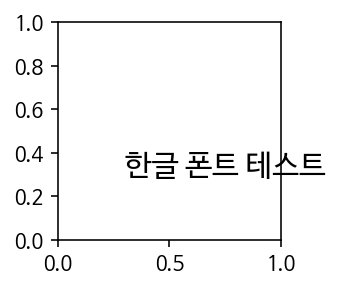

In [ ]:
# 그래프 한글 폰트 설정 (한번 돌린 후 런타임 다시시작하고 다시 돌려야 제대로 나옴)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

from IPython.display import set_matplotlib_formats
#폰트 선명하게 보이게 하기 위해
set_matplotlib_formats('retina')

## Test
plt.figure(figsize=(2,2))
plt.text(0.3, 0.3, '한글 폰트 테스트', size=15)
plt.show()

## __본론__

## __본론1. 데이터 전처리__ 

### __1-1. 생활인구 데이터 전처리__

In [ ]:
pop=pd.read_csv('popl.csv')

In [ ]:
# 칼럼명 바꾸기 & fore_pop_2 열 삭제 
pop = pop.rename(columns = {'base_ymd' : 'date', 'ori_table' : 'hour', 'tmzon_se_code' : 'gender', 'sexdstn_se_code' : 'age_old',
                            'agrde_se_code' : 'ad_dong_cd', 'adstrd_code' : 'korean', 'local_pop' : 'long_fn', 
                            'fore_pop_1' : 'short_fn' })
pop.drop(['fore_pop_2'], axis = 1, inplace = True)

In [ ]:
# int -> str -> pd.to_datetime(df['col'])
pop['date'] = pop['date'].astype(str)
pop['date'] = pd.to_datetime(pop['date'])

In [ ]:
# month, dow: 달, 요일 분류
pop['month'] = pop['date'].dt.month 
pop['dow'] = pop['date'].dt.weekday + 1

In [ ]:
# 가독성 위해서 (10-14, 15-19 등으로 구분)
pop['age'] = np.where(pop['age_old'] == 'age_00', '0-9', 
                np.where(pop['age_old'] == 'age_10', '10-14',  
                  np.where(pop['age_old'] == 'age_15', '15-19', 
                    np.where(pop['age_old'] == 'age_20', '20-24',  
                      np.where(pop['age_old'] == 'age_25', '25-29', 
                        np.where(pop['age_old'] == 'age_30', '30-34', 
                          np.where(pop['age_old'] == 'age_35', '35-39',  
                            np.where(pop['age_old'] == 'age_40', '40-44',
                              np.where(pop['age_old'] == 'age_45', '45-49',  
                               np.where(pop['age_old'] == 'age_50', '50-54', 
                                 np.where(pop['age_old'] == 'age_55', '55-59', 
                                   np.where(pop['age_old'] == 'age_60', '60-64', 
                                     np.where(pop['age_old'] == 'age_65', '65-69', '70+')))))))))))))

In [ ]:
# 연령대 변수 만들기 (10대, 20대 등)
pop['age_grp'] = np.where(pop['age_old'] == 'age_00', '0s', 
                np.where(pop['age_old'] == 'age_10', '10s',  
                  np.where(pop['age_old'] == 'age_15', '10s', 
                    np.where(pop['age_old'] == 'age_20', '20s',  
                      np.where(pop['age_old'] == 'age_25', '20s', 
                        np.where(pop['age_old'] == 'age_30', '30s', 
                          np.where(pop['age_old'] == 'age_35', '30s',  
                            np.where(pop['age_old'] == 'age_40', '40s',
                              np.where(pop['age_old'] == 'age_45', '40s',  
                               np.where(pop['age_old'] == 'age_50', '50s', 
                                 np.where(pop['age_old'] == 'age_55', '50s', 
                                   np.where(pop['age_old'] == 'age_60', '60s', 
                                     np.where(pop['age_old'] == 'age_65', '60s', '70+')))))))))))))

In [ ]:
admin_dong = pd.read_csv('행정동코드_매핑정보_2018.csv')
admin_dong = admin_dong.rename(columns = {'행자부행정동코드' : 'ad_dong_cd', '시도명' : 'sido', '시군구명' : 'sigungu', '행정동명' : 'ad_dong'})

In [ ]:
pop = pd.merge(pop, admin_dong[['ad_dong_cd', 'sido', 'sigungu', 'ad_dong']], how = 'left',on = 'ad_dong_cd')
pop.head()

date  hour gender age_old  ad_dong_cd  korean  long_fn  short_fn  \
0 2020-02-12     2      F  age_50    11110515     205        0         0   
1 2020-02-12     2      F  age_15    11110515      78        0         0   
2 2020-02-12    21      F  age_10    11110515      28        0         0   
3 2020-02-12     7      F  age_10    11110515      49        0         0   
4 2020-02-12    16      M  age_25    11110515     291        0         0   

   month  dow    age age_grp sido sigungu ad_dong  
0      2    3  50-54     50s   서울     종로구   청운효자동  
1      2    3  15-19     10s   서울     종로구   청운효자동  
2      2    3  10-14     10s   서울     종로구   청운효자동  
3      2    3  10-14     10s   서울     종로구   청운효자동  
4      2    3  25-29     20s   서울     종로구   청운효자동

### __1-2. 배달 호출 데이터 전처리__

In [ ]:
deliv=pd.read_csv('dlvr_call.csv')

In [ ]:
# 칼럼명 바꾸기 
deliv = deliv.rename(columns = {'SN' : 'num', 'PROCESS_DT' : 'date', 
                        'DLVR_REQUST_ENTRPS_ID': 'req_entp', 'DLVR_REQUST_STTUS_VALUE': 'status', 'DLVR_RCEPT_ENTRPS_ID': 'rec_entp', 
                        'DLVR_STORE_ID' : 'str_id', 'DLVR_STORE_INDUTY_NM' : 'str_ind', 
                        'DLVR_STORE_LEGALDONG_CODE': 'str_legalcode', 'DLVR_STORE_BRTC_NM' : 'str_sido', # 음식점 위치 정보 
                        'DLVR_STORE_SIGNGU_NM' : 'str_sigungu', 'DLVR_STORE_LEGALDONG_NM' : 'str_legaldong', 'DLVR_STORE_LI_NM' : 'str_li', 
                        'DLVR_STORE_ADSTRD_CODE': 'str_admincode', 'DLVR_STORE_RDNMADR_CODE' : 'str_roadadd', 
                        'DLVR_DSTN_LEGALDONG_CODE' : 'dest_legalcode', 'DLVR_DSTN_BRTC_NM' : 'dest_sido', # 배달목적지 위치정보 
                        'DLVR_DSTN_SIGNGU_NM' : 'dest_sigungu', 'DLVR_DSTN_LEGALDONG_NM' : 'dest_legaldong', 'DLVR_DSTN_LI_NM' : 'dest_li', 
                        'DLVR_DSTN_ADSTRD_CODE' : 'dest_admincode', 'DLVR_DSTN_RDNMADR_CODE' : 'dest_roadadd', 
                        'DLVR_MAN_ID' : 'delivman_id', 'DLVR_AMOUNT' : 'deliv_fee', 'CALL_RLAY_FEE_AMOUNT' : 'serv_charge', # 배달기사, 배달비, 수수료 
                        'GOODS_AMOUNT' : 'goods_amount', 'SETLE_KND_VALUE' : 'how_paid', 'SETLE_CARD_NM' : 'card_comp', # 결제 정보 
                        'DLVR_RCEPT_TIME' : 'deliv_order_time', 'DLVR_CARALC_TIME' : 'deliv_time', # 배달 시간 관련 정보 
                        'DLVR_RECPT_TIME' : 'deliv_rec_time', 'DLVR_COMPT_TIME' : 'deliv_complt_time', 'DLVR_CANCL_TIME' : 'deliv_cancl_time'})

In [ ]:
# 1) 상품금액 0인 행 삭제 (오류라 생각)
deliv = deliv[deliv['goods_amount'] > 0] # 상품금액이 0보다 큰 행만 추출 
deliv.shape # 약 40만 개의 행이 삭제됨 

(3883409, 32)

In [ ]:
# 2) 배달 취소한 데이터는 행 삭제 
# 또 다른 방법은 배달상태 (status)가 1 (완료)인 것만 추출 
deliv = deliv[deliv['deliv_cancl_time'].apply(lambda x: len(x.split(' ')) < 2)]
deliv.shape

(3818548, 32)

In [ ]:
# 배달요청업체, 배달접수업체, 카드회사 (결측치 많아서), 배달취소시간 열(변수) 삭제 
deliv.drop(['req_entp', 'rec_entp', 'card_comp', 'deliv_cancl_time'], axis = 1, inplace = True) 
deliv.shape

(3818548, 28)

In [ ]:
# 칼럼에 포함된 \n 제거 
deliv['deliv_time']=deliv['deliv_time'].str.strip('\\N')
deliv['deliv_rec_time']=deliv['deliv_rec_time'].str.strip('\\N')
deliv['deliv_complt_time']=deliv['deliv_complt_time'].str.strip('\\N')
deliv['str_li']=deliv['str_li'].str.strip('\\N')
deliv['dest_li']=deliv['dest_li'].str.strip('\\N')

In [ ]:
# 4) 날짜 변수 datetime으로 바꾸기 
deliv['date'] = pd.to_datetime(deliv['date'], format='%Y-%m-%d')
deliv['deliv_time']=pd.to_datetime(deliv['deliv_time'],format='%Y-%m-%d %H:%M:%S')
deliv['deliv_order_time']=pd.to_datetime(deliv['deliv_order_time'],format='%Y-%m-%d %H:%M:%S')
deliv['deliv_rec_time']=pd.to_datetime(deliv['deliv_rec_time'],format='%Y-%m-%d %H:%M:%S')
deliv['deliv_complt_time']=pd.to_datetime(deliv['deliv_complt_time'],format='%Y-%m-%d %H:%M:%S')

### __1-3. 업종 지역별 창업, 폐업 유추 데이터 전처리__

In [ ]:
company_reg=pd.read_csv('StartupOrClosing_Region_ver2.csv')
company_reg['DATE']=pd.to_datetime(company_reg['DATE'],format='%Y%m%d')

In [ ]:
# 경도 위도에 포함된 *** 제거
company_reg['LA_DCMLPOINT_VALUE']=company_reg['LA_DCMLPOINT_VALUE'].str.strip('***')
company_reg['LO_DCMLPOINT_VALUE']=company_reg['LO_DCMLPOINT_VALUE'].str.strip('***')
company_reg['LA_DCMLPOINT_VALUE']=company_reg['LA_DCMLPOINT_VALUE'].astype(float)
company_reg['LO_DCMLPOINT_VALUE']=company_reg['LO_DCMLPOINT_VALUE'].astype(float)

In [ ]:
# 같은 명칭(경기도=경기, 전라남도=전남)이 다르게 표시된 것 통일
company_reg['BRTC_NM']=company_reg['BRTC_NM'].str.replace('경기도','경기')
company_reg['BRTC_NM']=company_reg['BRTC_NM'].str.replace('전라남도','전남')

### __1-4. 날씨 데이터 전처리__

In [ ]:
w=pd.read_csv('weather.csv')
w['date']=pd.to_datetime(w['date'])
w['year']=w['date'].dt.year

In [ ]:
# 2020년 서울 날씨 데이터만 추출
w20=w[w['year']==2020]
w20.drop(['year'],axis=1,inplace=True)
weather=w20[(w20['province']=='Seoul')]
weather.head()

code province       date  avg_temp  min_temp  max_temp  precipitation  \
23375  10000    Seoul 2020-01-01      -2.2      -6.5       0.3            0.0   
23391  10000    Seoul 2020-01-02       1.0      -0.7       3.8            0.0   
23407  10000    Seoul 2020-01-03      -0.1      -3.4       4.6            0.0   
23423  10000    Seoul 2020-01-04       1.2      -2.8       6.1            0.0   
23439  10000    Seoul 2020-01-05       1.3      -3.2       6.6            0.0   

       max_wind_speed  most_wind_direction  avg_relative_humidity  
23375             2.6                 50.0                   64.4  
23391             4.0                 50.0                   65.4  
23407             3.5                290.0                   56.9  
23423             4.5                 50.0                   50.8  
23439             2.9                 50.0                   45.6

## __본론2. 데이터 시각화__ 

### __2-1. 업종 지역별 창업, 폐업 유추 데이터 시각화__

In [ ]:
company_reg['month'],company_reg['day']=(company_reg['DATE'].dt.month, company_reg['DATE'].dt.day)

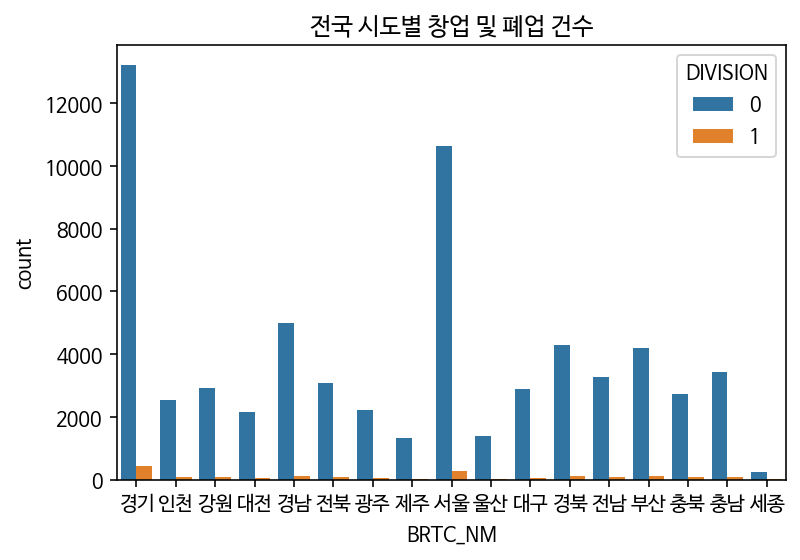

In [ ]:
plt.figure()
sns.countplot(x='BRTC_NM',data=company_reg,hue='DIVISION')
plt.title('전국 시도별 창업 및 폐업 건수')
plt.show()
#0=폐업, 1=창업

* 폐업(0)수가 창업수에 비해 압도적이고 경기, 서울순의 분포를 보인다. 

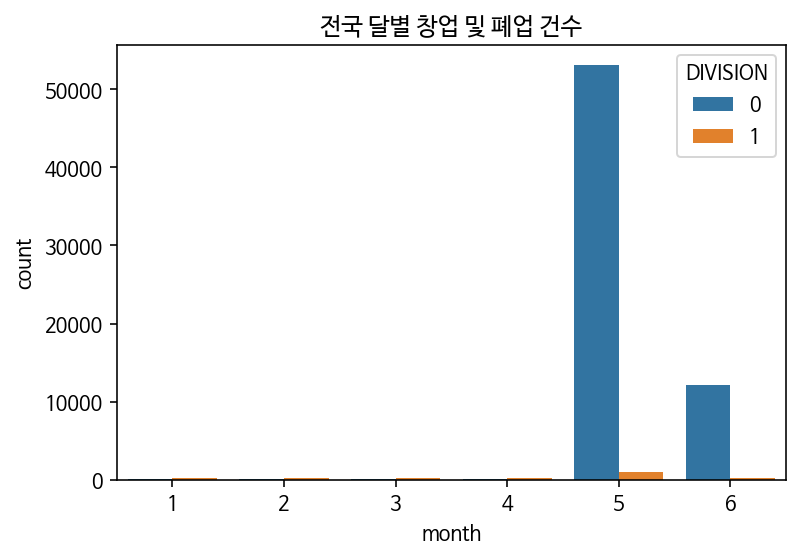

In [ ]:
plt.figure()
sns.countplot(x='month',hue='DIVISION', data=company_reg)
plt.title('전국 월별 창업 및 폐업 건수')
plt.show()
# 1 = 창업, 0 = 폐업

* 폐업이 2020년 5월에 급격히 늘어났음을 알 수 있다.

In [ ]:
#서울만 추출
comp_seoul=company_reg[(company_reg['BRTC_NM']=='서울')]

In [ ]:
# 서울시 구별 창업 폐업 건수
comp_s_count=pd.DataFrame(comp_seoul.groupby('SIGUNGU_NM')['DIVISION'].value_counts())
comp_s_count.rename(columns={'DIVISION':'count'},inplace=True)
comp_s_count.reset_index(inplace=True)

In [ ]:
# 서울시 창업만 추출
seoul_open=comp_s_count[comp_s_count['DIVISION']==1]
seoul_open.sort_values(by='count',ascending=False, inplace=True)
# 서울시 폐업만 추출
seoul_cld=comp_s_count[comp_s_count['DIVISION']==0]
seoul_cld.sort_values(by='count',ascending=False, inplace=True)

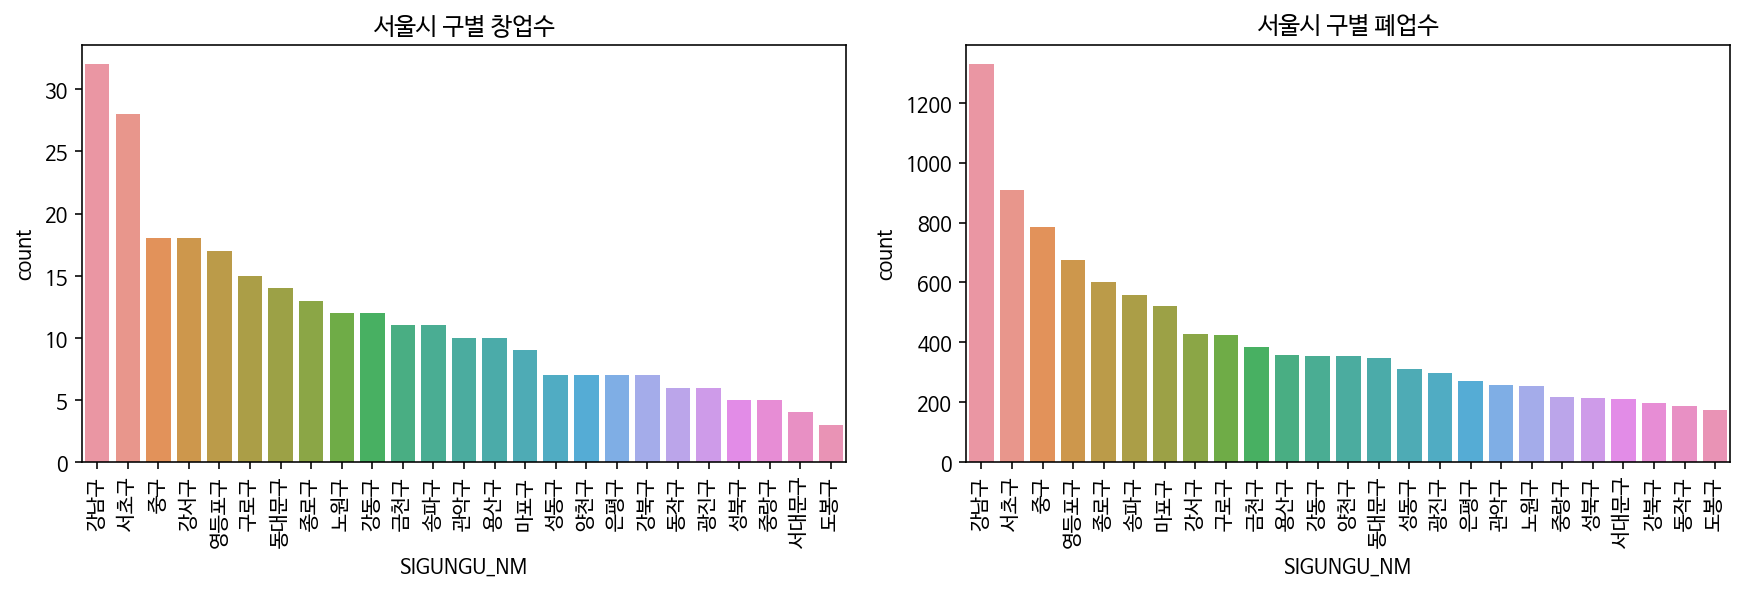

In [ ]:
fig, ax= plt.subplots(figsize=(12,4),ncols=2, constrained_layout=True)
plot1= sns.barplot(data=seoul_open,x='SIGUNGU_NM',y='count', ax=ax[0])
plot1.set_xticklabels(plot1.get_xticklabels(),rotation=90)

plot2=sns.barplot(data=seoul_cld,x='SIGUNGU_NM',y='count', ax=ax[1])
plot2.set_xticklabels(plot2.get_xticklabels(),rotation=90)

ax[0].set_title('서울시 구별 창업수')
ax[1].set_title('서울시 구별 폐업수')

plt.show()

### __2-2. 코로나 데이터 시각화__

#### Time 데이터

In [ ]:
# time.csv 데이터 
time=pd.read_csv('Time.csv')
time['date']=pd.to_datetime(time['date'])

# 일별 신규 확진자 변수 만들기 
time['new'] = 0
for i in range(1, len(time)): 
  time.iloc[i, 7] = time.iloc[i, 4] - time.iloc[(i-1), 4]
time.head()

date  time  test  negative  confirmed  released  deceased  new
0 2020-01-20    16     1         0          1         0         0    0
1 2020-01-21    16     1         0          1         0         0    0
2 2020-01-22    16     4         3          1         0         0    0
3 2020-01-23    16    22        21          1         0         0    0
4 2020-01-24    16    27        25          2         0         0    1

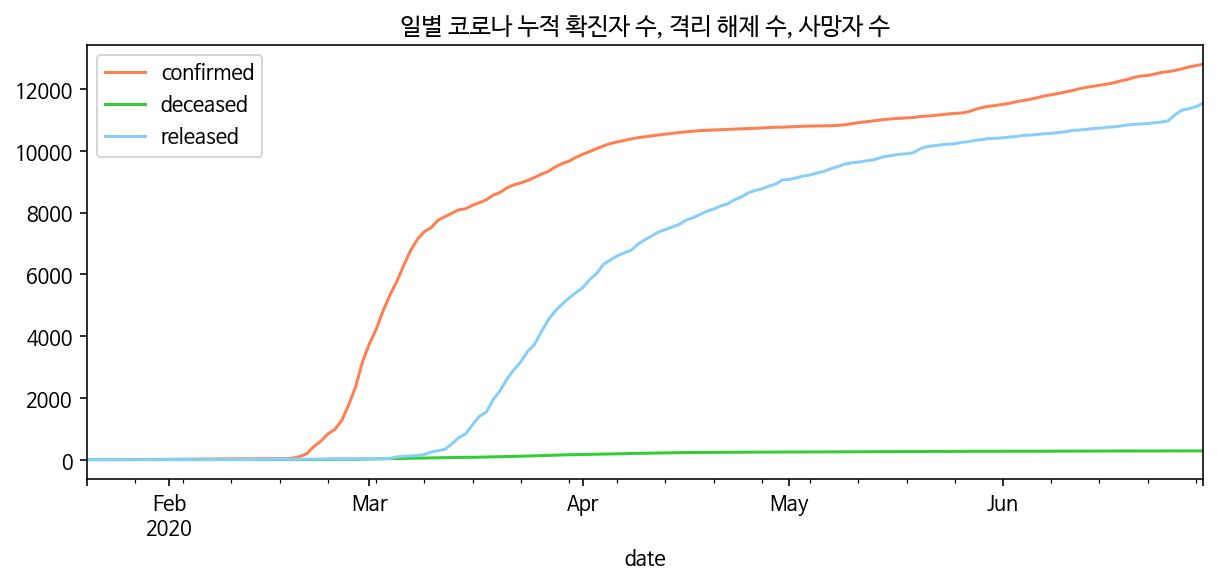

In [ ]:
time.plot(x = 'date', y = ['confirmed', 'deceased', 'released'], figsize = (10, 4), color = ['coral', 'limegreen', 'lightskyblue'])
plt.title('일별 코로나 누적 확진자 수, 격리 해제 수, 사망자 수')
plt.show()

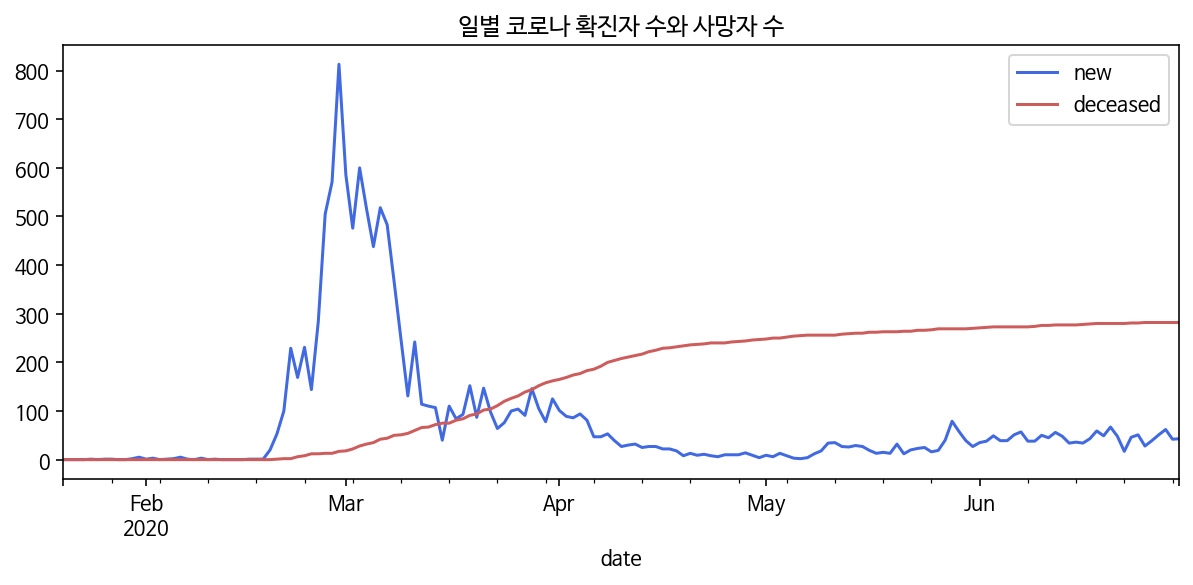

In [ ]:
time.plot(x = 'date', y = ['new', 'deceased'], figsize = (10, 4), color = ['royalblue', 'indianred'])
plt.title('일별 코로나 확진자 수와 사망자 수')
plt.show()

#### TimeAge 데이터

In [ ]:
# TimeAge 데이터
time_age=pd.read_csv('TimeAge.csv')
time_age['date']=pd.to_datetime(time_age['date'])
time_age.head()

date  time  age  confirmed  deceased
0 2020-03-02     0   0s         32         0
1 2020-03-02     0  10s        169         0
2 2020-03-02     0  20s       1235         0
3 2020-03-02     0  30s        506         1
4 2020-03-02     0  40s        633         1

Text(0.5, 1.0, '일별 연령대별 확진자 수')

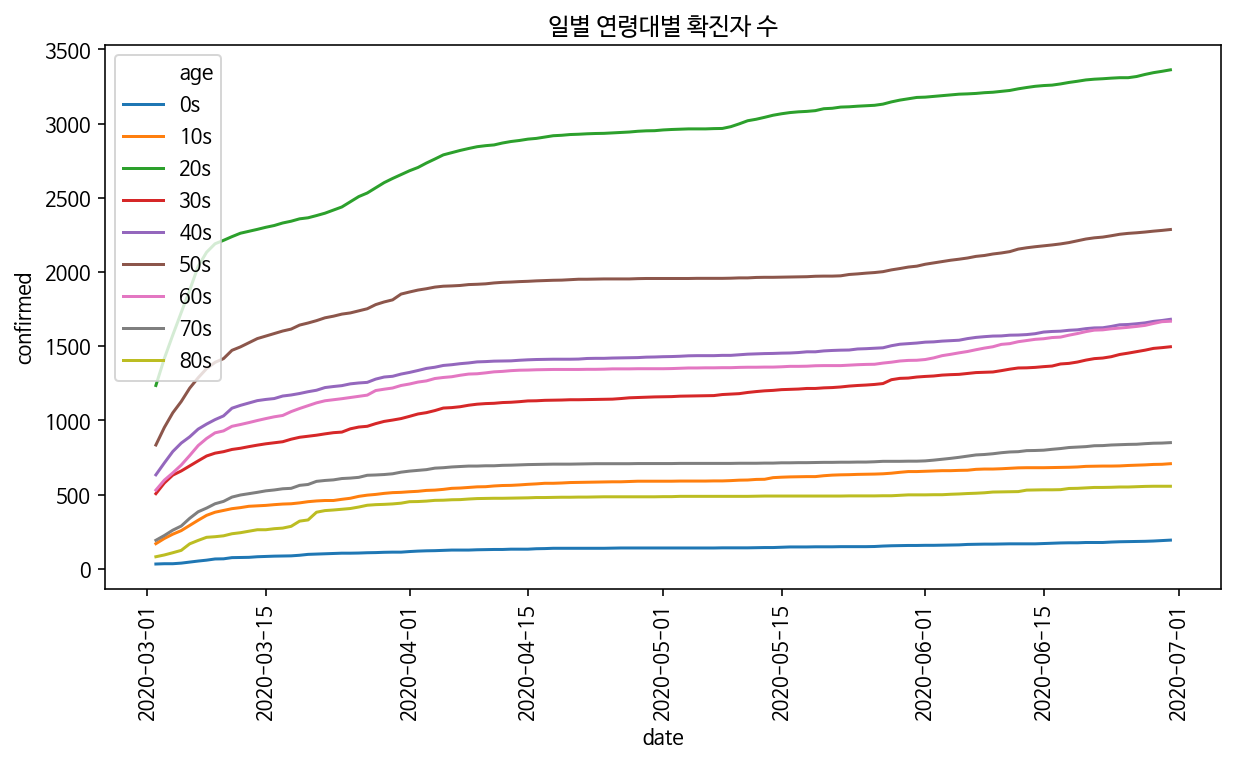

In [ ]:
cor_age_day=time_age.groupby(['date','age'])['confirmed','deceased'].sum().reset_index()
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.lineplot(data=cor_age_day,x='date',y='confirmed',hue='age')
plt.title('일별 연령대별 확진자 수')

* 일별 코로나 확진자 수는 20대가 제일 많았고 50대가 그 뒤를 이었다.

#### TimeGender 데이터

In [ ]:
time_gender=pd.read_csv('TimeGender.csv')
time_gender['date']=pd.to_datetime(time_gender['date'])
time_gender.head()

date  time     sex  confirmed  deceased
0 2020-03-02     0    male       1591        13
1 2020-03-02     0  female       2621         9
2 2020-03-03     0    male       1810        16
3 2020-03-03     0  female       3002        12
4 2020-03-04     0    male       1996        20

Text(0.5, 1.0, '일별 성별 확진자 수')

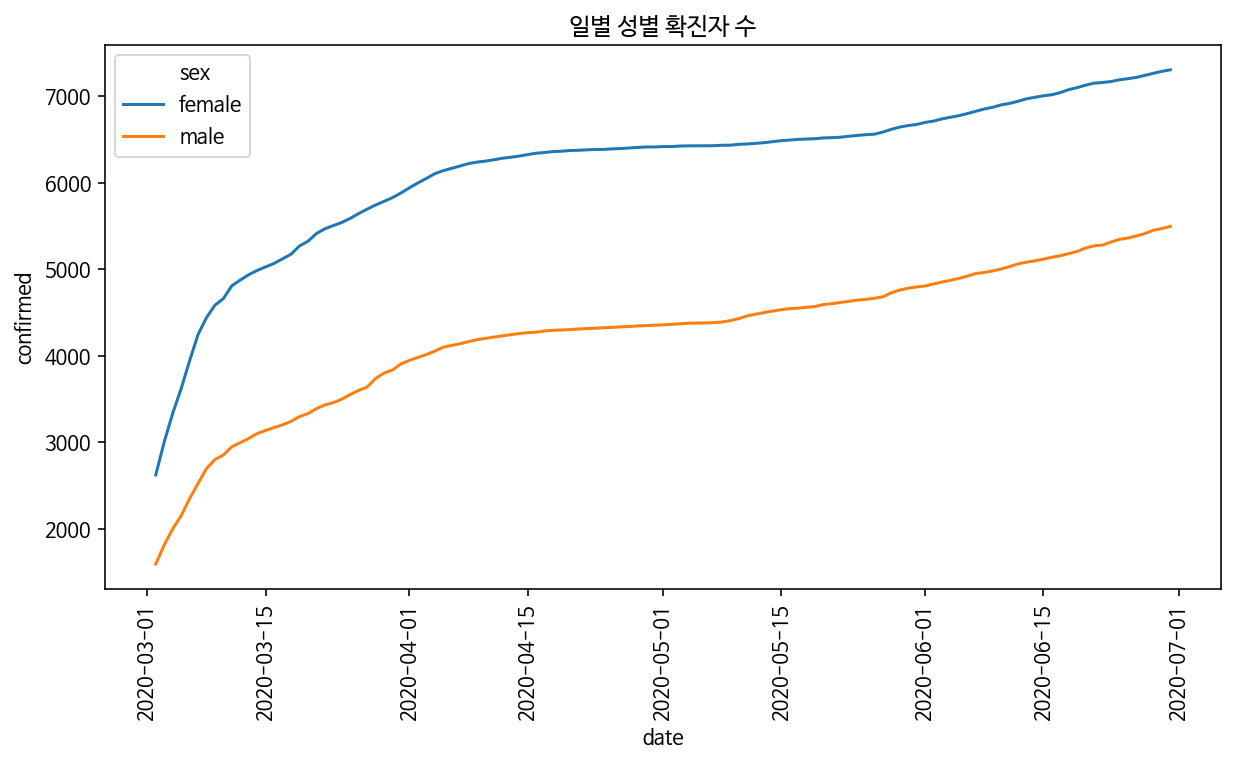

In [ ]:
cor_sex_day=time_gender.groupby(['date','sex'])['confirmed','deceased'].sum().reset_index()
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.lineplot(data=cor_sex_day,x='date',y='confirmed',hue='sex')
plt.title('일별 성별 확진자 수')

* 일별 코로나 확진자 수는 여성이 남성보다 더 많았다.

### __2-3. 날씨 데이터 시각화__

In [ ]:
# 2020년 서울 일별 평균 데이터 생성
all_wea=weather.groupby('date').mean().reset_index()
all_wea.drop(['code'],axis=1,inplace=True)
all_wea.head()

date  avg_temp  min_temp  max_temp  precipitation  max_wind_speed  \
0 2020-01-01      -2.2      -6.5       0.3            0.0             2.6   
1 2020-01-02       1.0      -0.7       3.8            0.0             4.0   
2 2020-01-03      -0.1      -3.4       4.6            0.0             3.5   
3 2020-01-04       1.2      -2.8       6.1            0.0             4.5   
4 2020-01-05       1.3      -3.2       6.6            0.0             2.9   

   most_wind_direction  avg_relative_humidity  
0                 50.0                   64.4  
1                 50.0                   65.4  
2                290.0                   56.9  
3                 50.0                   50.8  
4                 50.0                   45.6

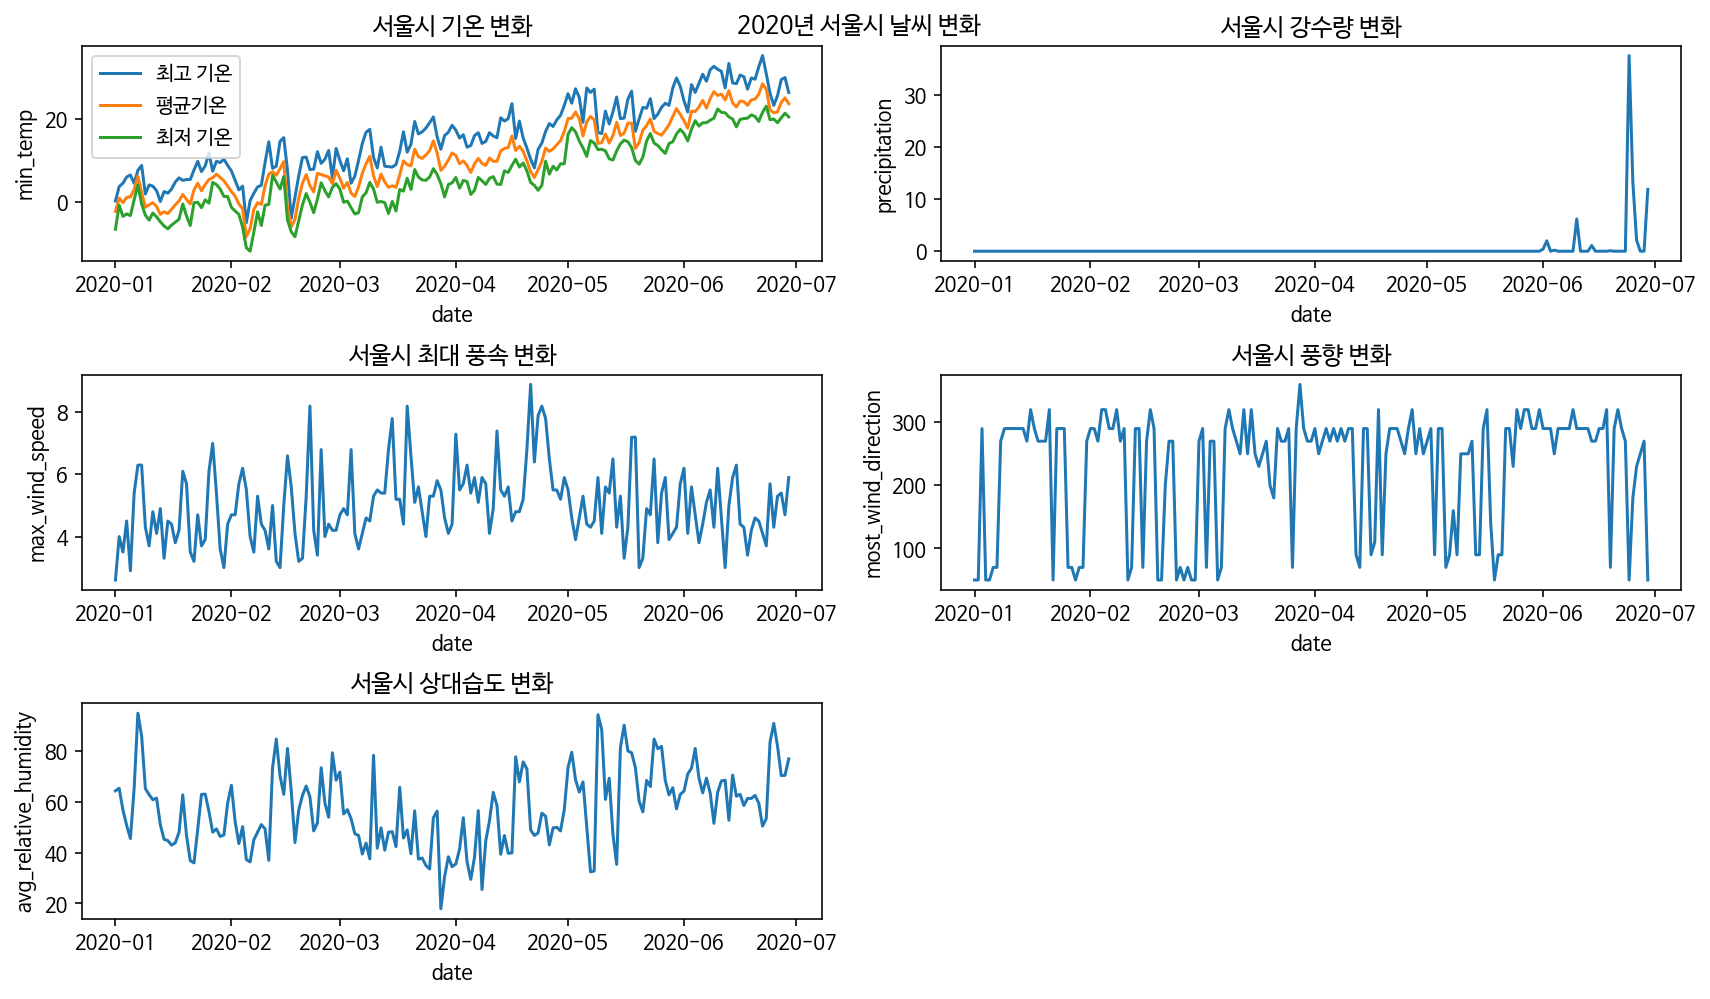

In [ ]:
plt.figure(figsize=(12,7))

ax1=plt.subplot(3,2,1)
g1=sns.lineplot(data=all_wea, x='date',y='max_temp',label='최고 기온')
g2=sns.lineplot(data=all_wea, x='date',y='avg_temp',label='평균기온')
g3=sns.lineplot(data=all_wea, x='date',y='min_temp',label='최저 기온')
ax1.set_title('서울시 기온 변화')
ax1.legend(loc='upper left')

ax2=plt.subplot(3,2,2)
g4=sns.lineplot(data=all_wea, x='date',y='precipitation')
ax2.set_title('서울시 강수량 변화')

ax3=plt.subplot(3,2,3)
g5=sns.lineplot(data=all_wea, x='date',y='max_wind_speed')
ax3.set_title('서울시 최대 풍속 변화')

ax4=plt.subplot(3,2,4)
g6=sns.lineplot(data=all_wea, x='date',y='most_wind_direction')
ax4.set_title('서울시 풍향 변화')

ax5=plt.subplot(3,2,5)
g7=sns.lineplot(data=all_wea, x='date',y='avg_relative_humidity')
ax5.set_title('서울시 상대습도 변화')

plt.suptitle('2020년 서울시 날씨 변화')
plt.tight_layout()
plt.show()

### __2-4. 배달 호출 데이터 시각화__

* 사용한 데이터 
  - ` dlvr_call.csv` (배달호출데이터)
* 주어진 배달 데이터를 자세하게 살펴보기 위해 간단하게 여러가지 시각화를 해보았는데, 그 중 의미있는 인사이트를 도출할 수 있는 시각화만 모아보았다. 

Text(0.5, 1.0, '결제수단 별 배달건수')

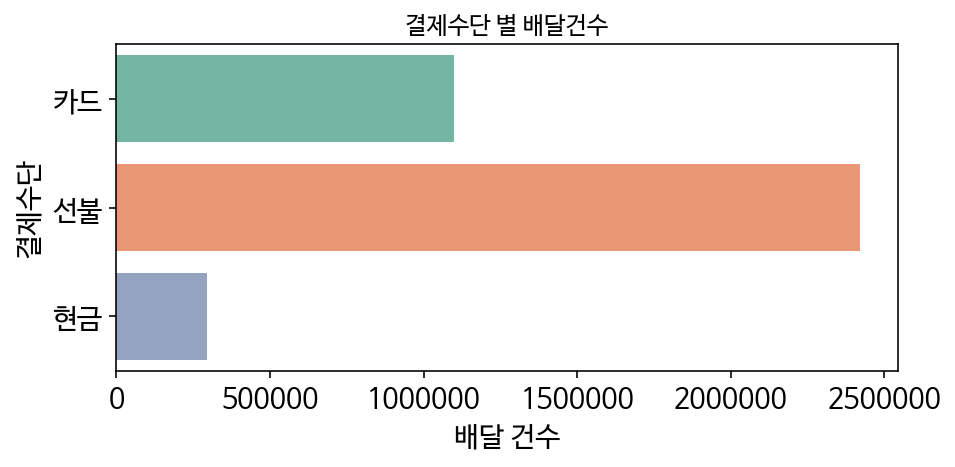

In [ ]:
# 결제수단 라벨링하기
deliv['how_paid_cat'] = np.where(deliv['how_paid'] == 1, '카드', 
                                np.where(deliv['how_paid'] == 2, '선불', '현금'))

# 히스토그램  
fig = plt.subplots(figsize = (7, 3))
a = sns.countplot(y = deliv.how_paid_cat, 
              dodge = True,
              palette = 'Set2')
a.ticklabel_format(style='plain', axis='x')
a.set_xlabel('배달 건수', fontsize = 14)
a.set_ylabel('결제수단', fontsize = 14)
plt.yticks(fontsize = 14); plt.xticks(fontsize = 14)
plt.title('결제수단 별 배달건수')

* 선불로 결제하는 경우가 압도적으로 제일 많았다.

In [ ]:
# 서울시 구별 배달비 평균 데이터셋
deliv_seoul_shop=deliv[deliv['str_sido']=='서울특별시']
seoul_fee=deliv_seoul_shop.groupby('str_sigungu')['deliv_fee'].mean().to_frame().sort_values(by='deliv_fee',ascending=False).reset_index()

Text(0.5, 1.0, '서울 구별(배달상점기준) 배달비 평균')

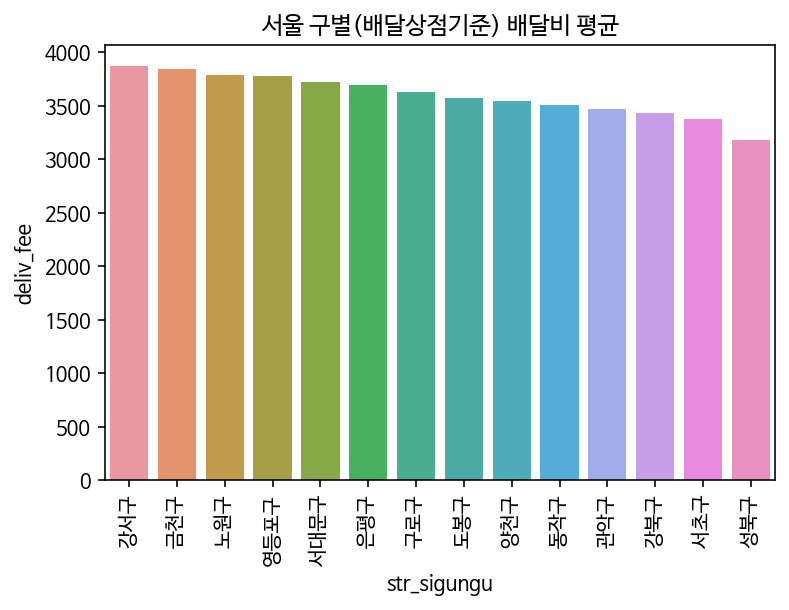

In [ ]:
plt.figure()
plt.xticks(rotation=90)
sns.barplot(data=seoul_fee, x='str_sigungu',y='deliv_fee')
plt.title('서울 구별(배달상점기준) 배달비 평균')

* 서울시 배달비는 대체로 3000원에서 4000원 사이에 분포한다. 

In [ ]:
# 배달호출 데이터 월 추출
deliv['month']=deliv['date'].dt.month

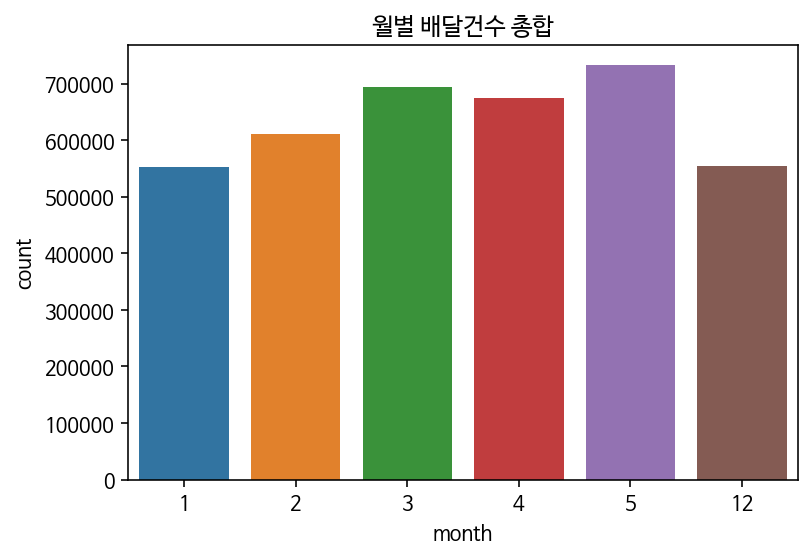

In [ ]:
plt.figure()
sns.countplot(x='month',data=deliv)
plt.title('월별 배달건수 총합')
plt.show()

* 2019년 12월부터 2020년 5월까지 월별 배달건수는 증가하는 경향을 보인다.

In [ ]:
# 배달호출데이터 시간 데이터 추출
deliv['order_hour'] = deliv['deliv_order_time'].dt.hour
deliv['caralc_hour']=deliv['deliv_time'].dt.hour
deliv['rec_hour']=deliv['deliv_rec_time'].dt.hour
deliv['compt_hour']=deliv['deliv_complt_time'].dt.hour

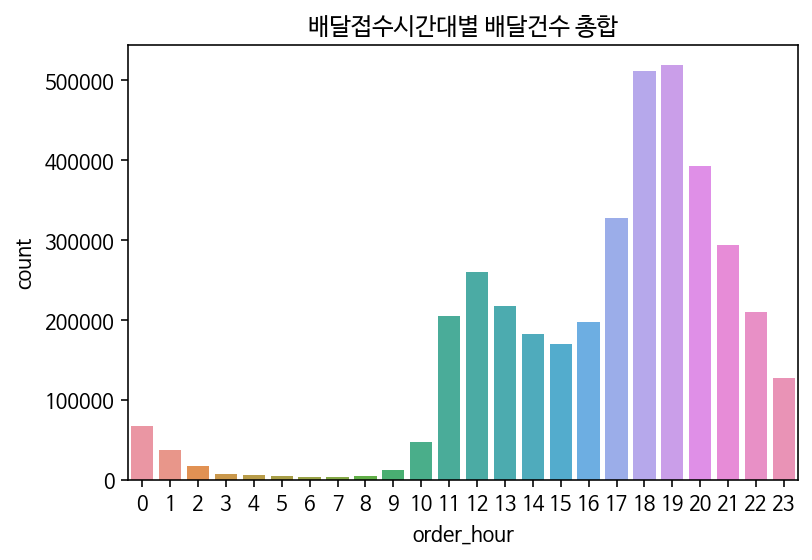

In [ ]:
#배달접수시간대별 count
plt.figure()
sns.countplot(x='order_hour',data=deliv)
plt.title('배달접수시간대별 배달건수 총합')
plt.show()

* 18시-20시에 배달접수 건수가 가장 많았다. 

### 요일 & 월별 패턴 
* (1) 배달 건수 
* (2) 상품 금액 

#### (1) 배달 건수 

In [ ]:
# 요일 & 월별 배달 건수 

# 1) 그룹별로 배달 건수를 count하는 함수 만들기
def group_sum(data, col): 
  df_tmp = pd.DataFrame(data[col].value_counts())
  df_tmp.rename(columns = {col: 'num_deliv'}, inplace = True)  
  df_sum = df_tmp.reset_index().rename(columns = {"index": "region"})  
  return df_sum

In [ ]:
# 2) 날짜별 배달 건수 데이터셋 만들기 
df_date = group_sum(deliv, 'date').rename(columns = {'region' : 'date'}) 

In [ ]:
# 3) 요일(dow), 월(month) 변수 만들기 
df_date['date'] = pd.to_datetime(df_date['date'])
df_date['month'] = df_date['date'].dt.strftime("%m")
df_date['dow'] = pd.to_datetime(df_date['date']).dt.weekday + 1
df_date.head()

date  num_deliv month  dow
0 2020-03-01      54624    03    7
1 2020-05-09      30156    05    6
2 2020-05-31      30132    05    7
3 2020-05-24      30118    05    7
4 2020-01-06      29932    01    1

In [ ]:
# 4) 피벗테이블로 바꾸기 
df_td = df_date.groupby(['dow', 'month'])['num_deliv'].mean().reset_index().pivot('dow', 'month', 'num_deliv')
df_td.head(4)

month        01        02        03        04            05       12
dow                                                                 
1      19991.75  17303.00  17663.40  18654.75  20713.666667  14318.0
2      15406.75  18362.50  19379.40  19525.00  22897.500000  20369.8
3      16674.00  19220.50  19163.75  21324.80  19878.500000  16813.0
4      15970.00  19034.75  19997.00  20511.60  20732.750000  15066.5

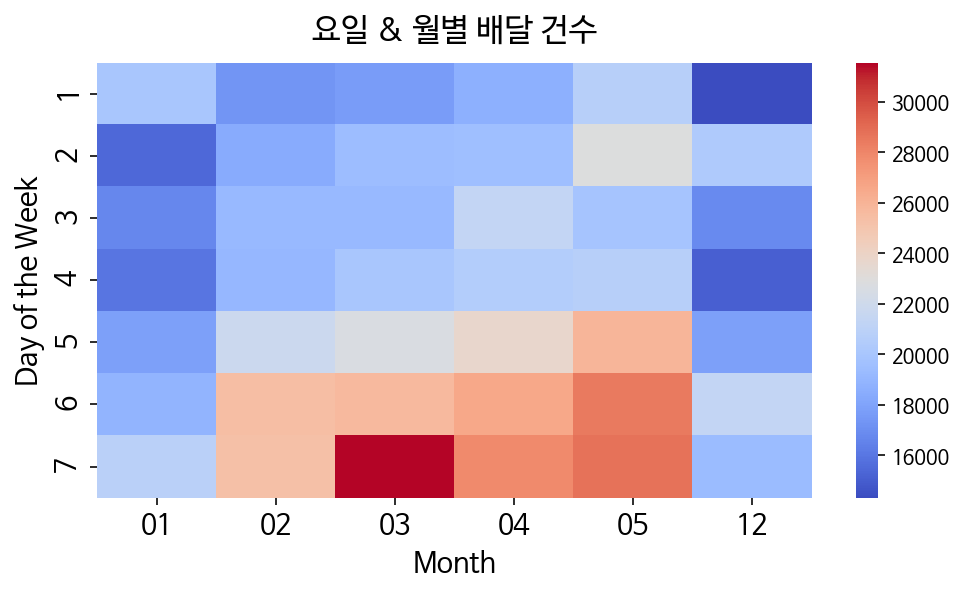

In [ ]:
# 5) 히트맵 시각화 
fig = plt.subplots(figsize = (8, 4))
ax = sns.heatmap(df_td, cmap='coolwarm')
ax.set_title('요일 & 월별 배달 건수', pad = 12, fontsize = 16)
ax.set_xlabel('Month', fontsize = 14)
ax.set_ylabel('Day of the Week', fontsize = 14)
plt.yticks(fontsize = 14); plt.xticks(fontsize = 14)
plt.show()

[ Insight ] - 배달 건수 
* 요일
  -  예상대로 금토일 (`dow = 5, 6, 7`)의 배달 건수가 다른 요일에 비해 많았다. 
      - 금토일 중에서도 일 > 토> 금 순서로 배달을 많이 시키는 경향이 있다.  
  - 평일 중에서는 월요일보다는 화,수,목요일에 배달을 더 많이 시킨다.  
* 월 
  - 배달 데이터셋이 2019년 2월부터 2020년 5월까지의 데이터셋임을 고려하면, 코로나 판데믹이 시작된 2월부터 배달 건수가 증가했음을 알 수 있다. 
  - 특히 3월의 일요일에 배달 건수가 매우 많고, 5월은 전반적으로 토요일과 일요일에 배달 건수가 많았다. 
      - 5월은 각종 가족 관련 휴일이 많다는 점 (어린이날, 어버이날 등)

#### (2) 상품 금액 

In [ ]:
# 요일 & 월별 상품 금액 

# 1) 날짜, 상품금액 변수만 추출하기 
df_date = deliv[['date', 'goods_amount']]

In [ ]:
# 2) 요일(dow), 월(month) 변수 만들기 - 앞과 동일 
df_date['date'] = pd.to_datetime(df_date['date'])
df_date['month'] = df_date['date'].dt.strftime("%m")
df_date['dow'] = pd.to_datetime(df_date['date']).dt.weekday + 1

In [ ]:
# 3) 피벗테이블로 만들기 (날짜별 상품금액의 평균으로 산출함)
df_td = df_date.groupby(['dow', 'month'])['goods_amount'].mean().reset_index().pivot('dow', 'month', 'goods_amount')
df_td.head(4)

month            01            02            03            04            05  \
dow                                                                           
1      22698.829280  22544.351630  22764.626890  22752.855091  23101.776186   
2      22615.913853  22863.730197  23163.469271  23309.593188  23518.773305   
3      22991.585175  22943.885045  23236.211219  23487.856149  23233.203952   
4      22945.386612  22976.754856  23256.232135  23404.695411  23428.840373   

month            12  
dow                  
1      22430.602319  
2      23917.897584  
3      23256.196678  
4      22680.670643

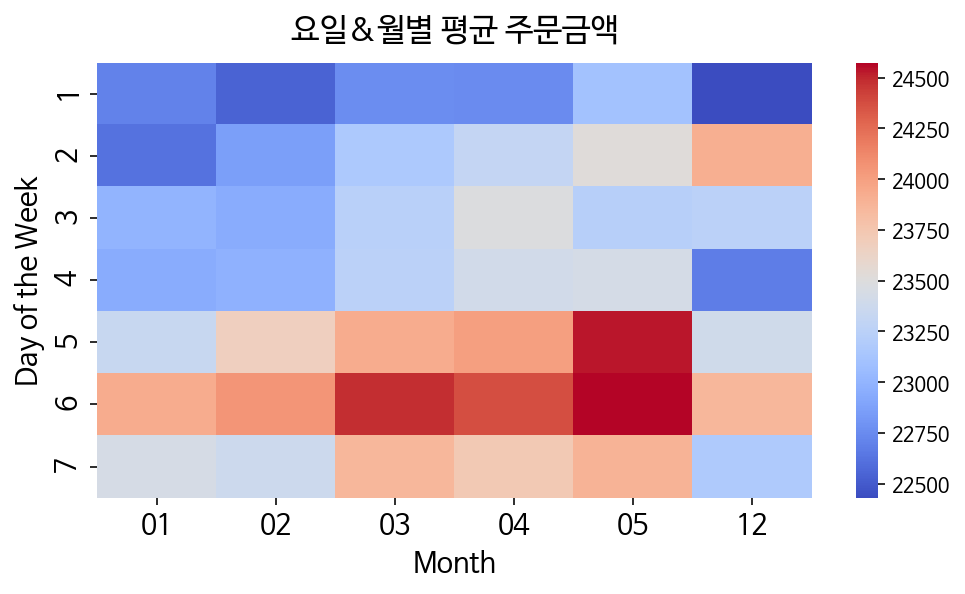

In [ ]:
# 4) 시각화 
fig = plt.subplots(figsize = (8, 4))
ax = sns.heatmap(df_td, cmap='coolwarm')
ax.set_title('요일&월별 평균 주문금액', pad = 12, fontsize = 16)
ax.set_xlabel('Month', fontsize = 14)
ax.set_ylabel('Day of the Week', fontsize = 14)
plt.yticks(fontsize = 14); plt.xticks(fontsize = 14)
plt.show()

[ Insight ] - 상품 금액 
* 요일 
  - 예상대로 금토일 (`dow = 5,6,7`)에 배달시킨 상품의 금액이 높다.
       - 금토일 중에서는 주로 토요일에 (`dow = 6`)가장 비싼 상품을 구매하는 것으로 나타난다. 이는 19년 12월부터 20년 5워까지 일관되게 나타나는 현상이다. 
  - 평일 내에서만 보면, 화수목 (`dow = 2,3,4`)에 배달시킨 상품 금액이 월요일보다 꽤 높았다. 
* 월 
  - 배달 건수와 비슷하게, 2-5월 동안 상품 금액이 높다. 
  - 특히 5월에 제일 비싼 상품을 주문하는 것으로 나타난다 (휴일이 많은 달). 


In [ ]:
# 1) 그룹별로 배달 건수를 count하는 함수 만들기 (중복)
def group_sum(data, col): 
  df_tmp = pd.DataFrame(data[col].value_counts())
  df_tmp.rename(columns = {col: 'num_deliv'}, inplace = True)  
  df_sum = df_tmp.reset_index().rename(columns = {"index": "region"})  
  return df_sum

In [ ]:
# 2) 업종별 배달 건수 데이터셋 만들기 
str_ind = group_sum(deliv, 'str_ind').rename(columns = {'region' : 'str_ind'}) 
str_ind.head(20)

str_ind  num_deliv
0       치킨     829342
1       한식     478109
2       분식     436775
3    족발/보쌈     334877
4   카페/디저트     330025
5    패스트푸드     261021
6   돈까스/일식     212457
7       피자     179212
8       야식     174076
9       찜탕     156533
10      중식     127453
11  아시안/양식      98600
12       회      83704
13  배달전문업체      79832
14     도시락      32328
15     심부름       4204

Text(0.5, 1.0, '업종별 배달 건수 (Top 10)')

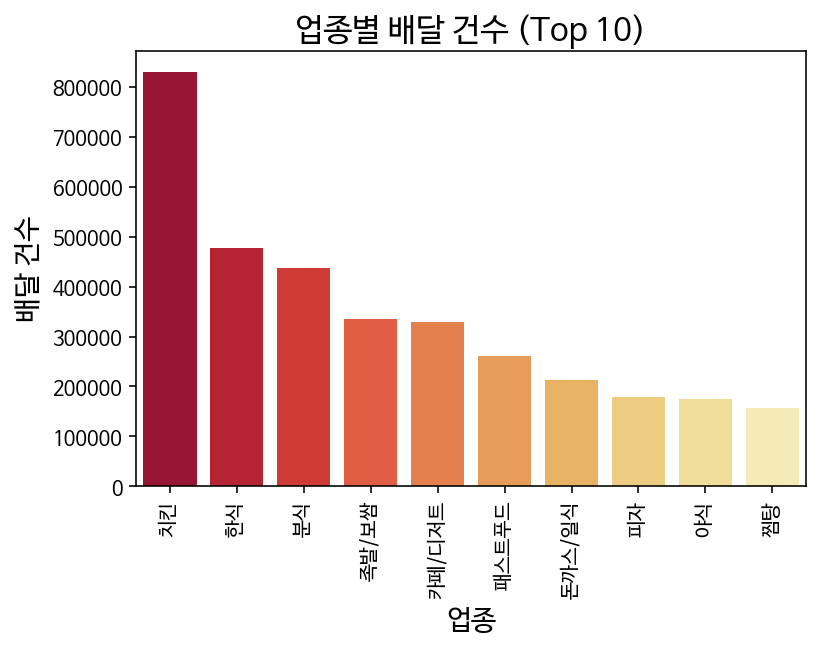

In [ ]:
# 3) 히스토그램  
ax = plt.plot()
ax = sns.barplot(x= 'str_ind', y = 'num_deliv', data = str_ind.head(10), palette = 'YlOrRd_r')
ax.set_xlabel('업종', fontsize = 14)
ax.set_ylabel('배달 건수', fontsize = 14)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.title('업종별 배달 건수 (Top 10)', fontsize = 16)

## __본론3. 코로나 확진자와 배달건수__ 

* 사용한 데이터 
  - `Time.csv` (코로나 데이터)
  - ` dlvr_call.csv` (배달호출데이터)
* 일별 코로나 확진자 수와 배달 건수 간 어떤 연관성이 있는지 살펴보기 위해, 시계열로 두 데이터를 시각화해보았다.  

In [ ]:
# 1-1) 코로나 데이터 - 일별 신규 확진자 변수 만들기 
time['new'] = 0
for i in range(1, len(time)): 
  time.iloc[i, 7] = time.iloc[i, 4] - time.iloc[(i-1), 4]

In [ ]:
# 1-2) 배달 데이터 - 일별 배달횟수 산출하기  
deliv_tmp = deliv[(deliv['date'] > '2020-01-19') & (deliv['date'] < '2020-07-01')]
deliv_day = pd.DataFrame(deliv_tmp.date.value_counts()).reset_index().sort_values(by = 'index', 
                                                                                  ascending=True, inplace=False, kind='quicksort')
deliv_day = deliv_day.rename(columns = {'index' : 'date', 'date' : 'num_deliv'})
deliv_day.head()

date  num_deliv
130 2020-01-20      14241
127 2020-01-21      14662
125 2020-01-22      15612
111 2020-01-23      17653
129 2020-01-24      14453

In [ ]:
# 2) 코로나 & 배달 데이터 merge (key값 : date) 
deliv_day['date'] = pd.to_datetime(deliv_day['date'])
deliv_covid = pd.merge(deliv_day, time[['date', 'new']], how = 'inner', on = 'date')
deliv_covid.head()

date  num_deliv  new
0 2020-01-20      14241    0
1 2020-01-21      14662    0
2 2020-01-22      15612    0
3 2020-01-23      17653    0
4 2020-01-24      14453    1

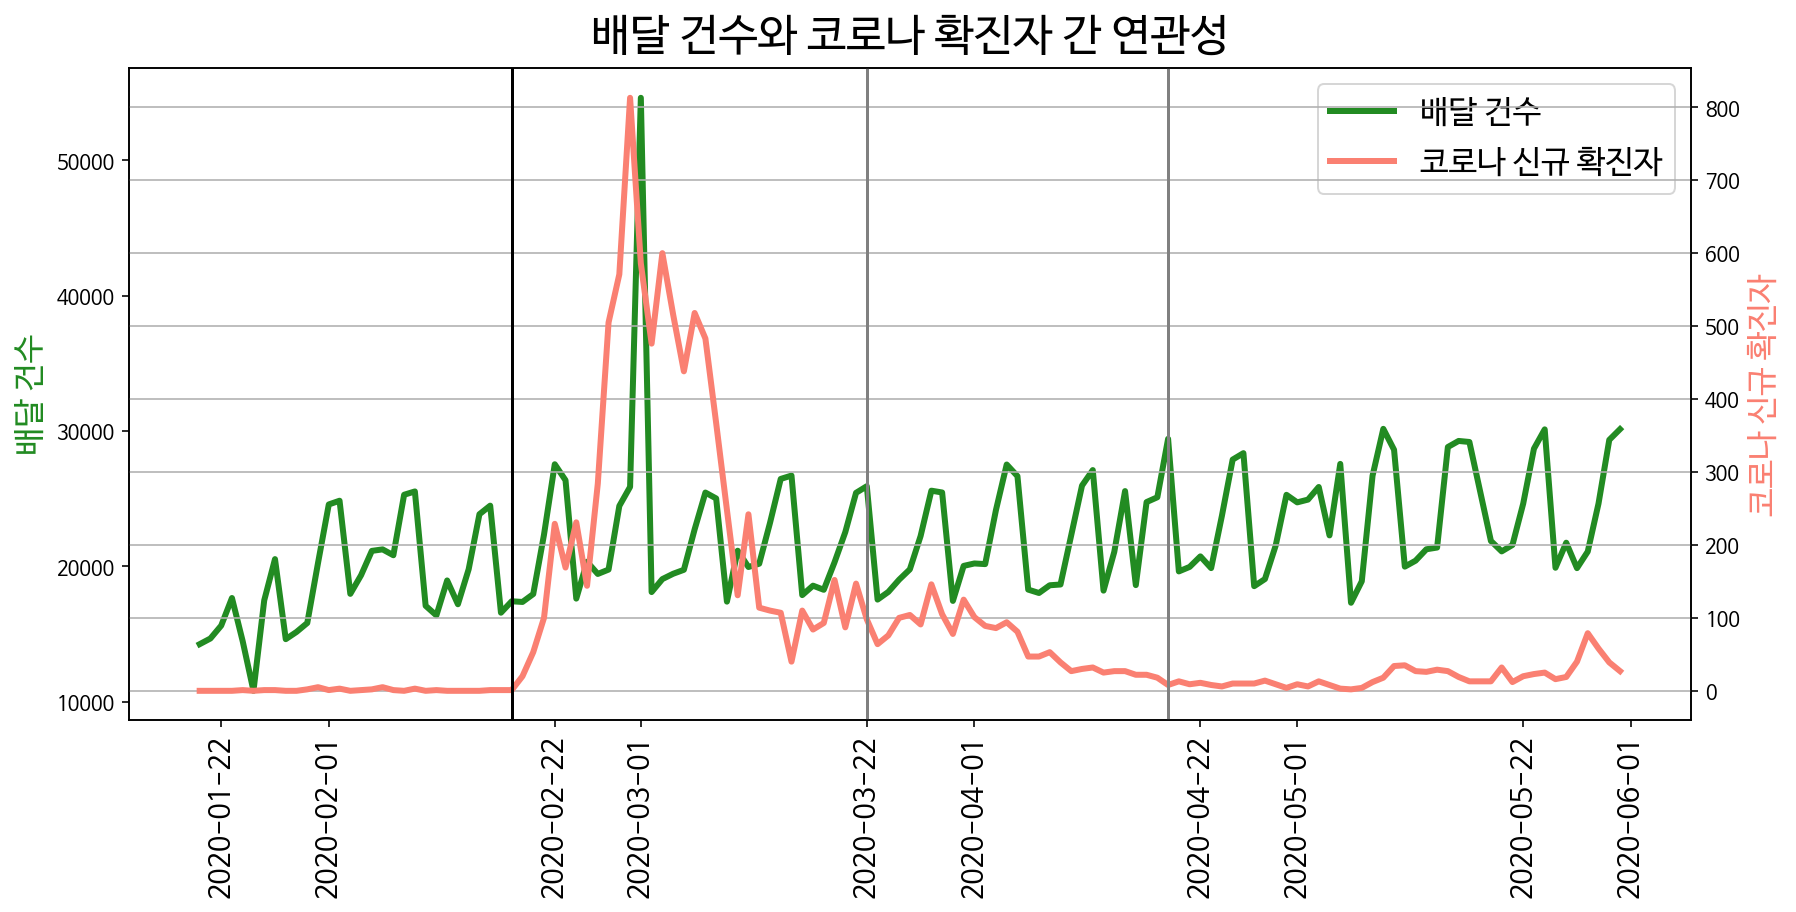

In [ ]:
# 3) 시계열 시각화 
plt.figure(figsize=(14, 6))
plt.title("배달 건수와 코로나 확진자 간 연관성", fontsize = 22, pad = 10)
plt.xticks(rotation=90, fontsize = 14)
ax1 = plt.subplot(111)
ax2 = ax1.twinx()
a, =  ax1.plot(deliv_covid["date"], deliv_covid["num_deliv"], "-", color='forestgreen', linewidth=3, label="배달 건수")
b, = ax2.plot(deliv_covid["date"], deliv_covid["new"], "-", color='salmon', linewidth=3, label="코로나 신규 확진자")
p = [a, b]
ax1.legend(p, [p_.get_label() for p_ in p], fontsize = 16)

ax1.set_ylabel('배달 건수', fontsize = 16, color='forestgreen')
ax2.set_ylabel('코로나 신규 확진자', fontsize = 16, color='salmon')

plt.grid(True)
plt.axvline(x= pd.to_datetime("2020-02-18"), color='black') # 신천지 관련 확진자 급증
plt.axvline(x= pd.to_datetime("2020-03-22"), color='grey') # 사회적거리두기 시작
plt.axvline(x= pd.to_datetime("2020-04-19"), color='grey') # 사회적거리두기 끝
plt.show()

### [ Insight ] 
* **신천지 관련 집단감염** 관련 
  - 2020년 2월 18일 이후부터 (검정색 선) 신천지 관련 확진자가 대구에서 급증하자, 서울과 경기도를 중심으로 한 배달 건수는 순간적으로 급증하였다. 
    - 일시적인 증가일 뿐, 3월부터는 기존의 증감 패턴과 비슷해졌다. 
    - 하지만 (1) 수도권 거주자들이 대구에서 벌어진 집단감염 이슈에 일시적이라도 반응했다는 점, 그리고 (2) 한국의 첫 집단감염 사례의 영향을 확인해보았다는 점은 눈여겨 볼 만하다. 

* **코로나 확진자 수 & 배달 건수 간 관계** 
    - 신천지 관련 집단감염 기간 외에는 코로나와 배달 건수 간 **큰 연관성은 보이지 않는다.** 
    - 코로나 신규 확진자수는 2020-04-01 이후로 서서히 줄어드는 반면, 배달 건수는 그 전과 큰 차이를 보이지 않는다. 
        - 특히, 사회적 거리두기를 강화한 시기(두 회색 선 사이 기간)에 코로나 확진자는 서서히 줄어들지만, 배달 건수는 늘어났다고 보기 어렵다.   
* 한계점 
    - 배달과 코로나 데이터 모두 20년 상반기까지의 데이터만 있었기 때문에, 20년 하반기와 21년 상반기도 두 요인의 연관성이 적었는지는 확인 불가능

## __본론4. 서울시 시간대별 생활인구 및 배달건수-사회적 거리두기 중심으로__

* 사용한 데이터 
  - `popl.csv` (행정동별 생활인구 데이터)
  - ` dlvr_call.csv` (배달호출데이터)
  - `행정동코드_매핑정보_2018.csv` (시군구 및 행정동 코드 데이터; 외부)

* 2020년 상반기의 사회적 거리두기 이전 (Before) , 동안 (During), 이후 (After)의 기간동안 시간대별 생활인구와 배달 건수가 어떻게 변하는지 살펴보았다. 


* 서울의 25개 지역구 중에서 15개의 지역구만 선택했다 
  - 나머지 10개의 지역구는 배달 데이터가 없거나 거의 없기 때문에, 배달 건수를 시각화할 수 없음 <br></br>

### 고려사항 
* 기간 설정 
  - 신천지 집단감염은 `2020-02-18`에 시작됨.
  - 사회적 거리두기는 `2020-03-22`부터 `2020-04-19`까지였음 (28일). 
  - 배달 건수는 `value_counts()`로 산출하기 때문에, 사회적 거리두기 이전 & 동안 & 이후는 같은 일수의 기간을 설정했음 (모두 28일).
     - Before : `2020-02-20 ~ 2020-03-18`
     - During : `2020-03-22 ~ 2020-04-19`
     - After : `2020-04-20 ~ 2020-05-18`
* 생활인구 대표값 
  - 시간대별 생활인구는 여러 날짜의 같은 시간대별 생활인구를 더한 후, 일수(28일)로 나누어 해당 기간동안 해당 시간대 생활인구의 평균으로 산출하였다.

In [ ]:
# 1) tidy data를 만드는 함수 정의하기 

# 1-1) 배달데이터 tidy version 만들기 
def make_tidy_deliv(gu_name): 
  deliv_seoul = deliv[deliv['dest_sido'] == '서울특별시']

  # 기간 설정 
  df1 = deliv_seoul[(deliv_seoul['dest_sigungu'] == gu_name) & (deliv_seoul['date'] > '2020-02-19') & (deliv_seoul['date'] < '2020-03-19')]
  df2 = deliv_seoul[(deliv_seoul['dest_sigungu'] == gu_name) & (deliv_seoul['date'] > '2020-03-21') & (deliv_seoul['date'] < '2020-04-20')]
  df3 = deliv_seoul[(deliv_seoul['dest_sigungu'] == gu_name) & (deliv_seoul['date'] > '2020-04-19') & (deliv_seoul['date'] < '2020-05-19')]

  df1['order_hour'] = df1['deliv_order_time'].dt.hour
  df2['order_hour'] = df2['deliv_order_time'].dt.hour
  df3['order_hour'] = df3['deliv_order_time'].dt.hour

  tmp1 = pd.DataFrame(df1['order_hour'].value_counts()).reset_index().rename(columns = {'index' : 'Hour', 'order_hour' : 'Before'})
  tmp2 = pd.DataFrame(df2['order_hour'].value_counts()).reset_index().rename(columns = {'index' : 'Hour', 'order_hour' : 'During'})
  tmp3 = pd.DataFrame(df3['order_hour'].value_counts()).reset_index().rename(columns = {'index' : 'Hour', 'order_hour' : 'After'})

  deliv_td_tmp = pd.merge(tmp1, tmp2, on = 'Hour', how = 'outer').sort_values(by = 'Hour', ascending=True, inplace=False, kind='quicksort')
  deliv_td = pd.merge(deliv_td_tmp, tmp3, on = 'Hour', how = 'outer').sort_values(by = 'Hour', ascending=True, inplace=False, kind='quicksort')

  return deliv_td

# 1-2) 생활인구 tidy version 만들기 
def make_tidy_pop(gu_name): 
    
  # 기간 설정 
  df_a = pop[(pop['sigungu'] == gu_name) & (pop['date'] > '2020-02-19') & (pop['date'] < '2020-03-19')]
  df_b = pop[(pop['sigungu'] == gu_name) & (pop['date'] > '2020-03-21') & (pop['date'] < '2020-04-20')]
  df_c = pop[(pop['sigungu'] == gu_name) & (pop['date'] > '2020-04-19') & (pop['date'] < '2020-05-19')]

  # 시간대별 생활인구의 대표값
  tmp_a = df_a['korean'].groupby(df_a['hour'])
  tmp_aa = pd.DataFrame(round(tmp_a.sum()/28, 1)).reset_index().rename(columns = {'korean' : 'Before'})

  tmp_b = df_b['korean'].groupby(df_b['hour'])
  tmp_bb = pd.DataFrame(round(tmp_b.sum()/28, 1)).reset_index().rename(columns = {'korean' : 'During'})

  tmp_c = df_c['korean'].groupby(df_c['hour'])
  tmp_cc = pd.DataFrame(round(tmp_c.sum()/28, 1)).reset_index().rename(columns = {'korean' : 'After'})

  pop_td_tmp = pd.merge(tmp_aa, tmp_bb, on = 'hour')
  pop_td = pd.merge(pop_td_tmp, tmp_cc, on = 'hour').rename(columns = {'hour' : 'Hour'})

  return pop_td 

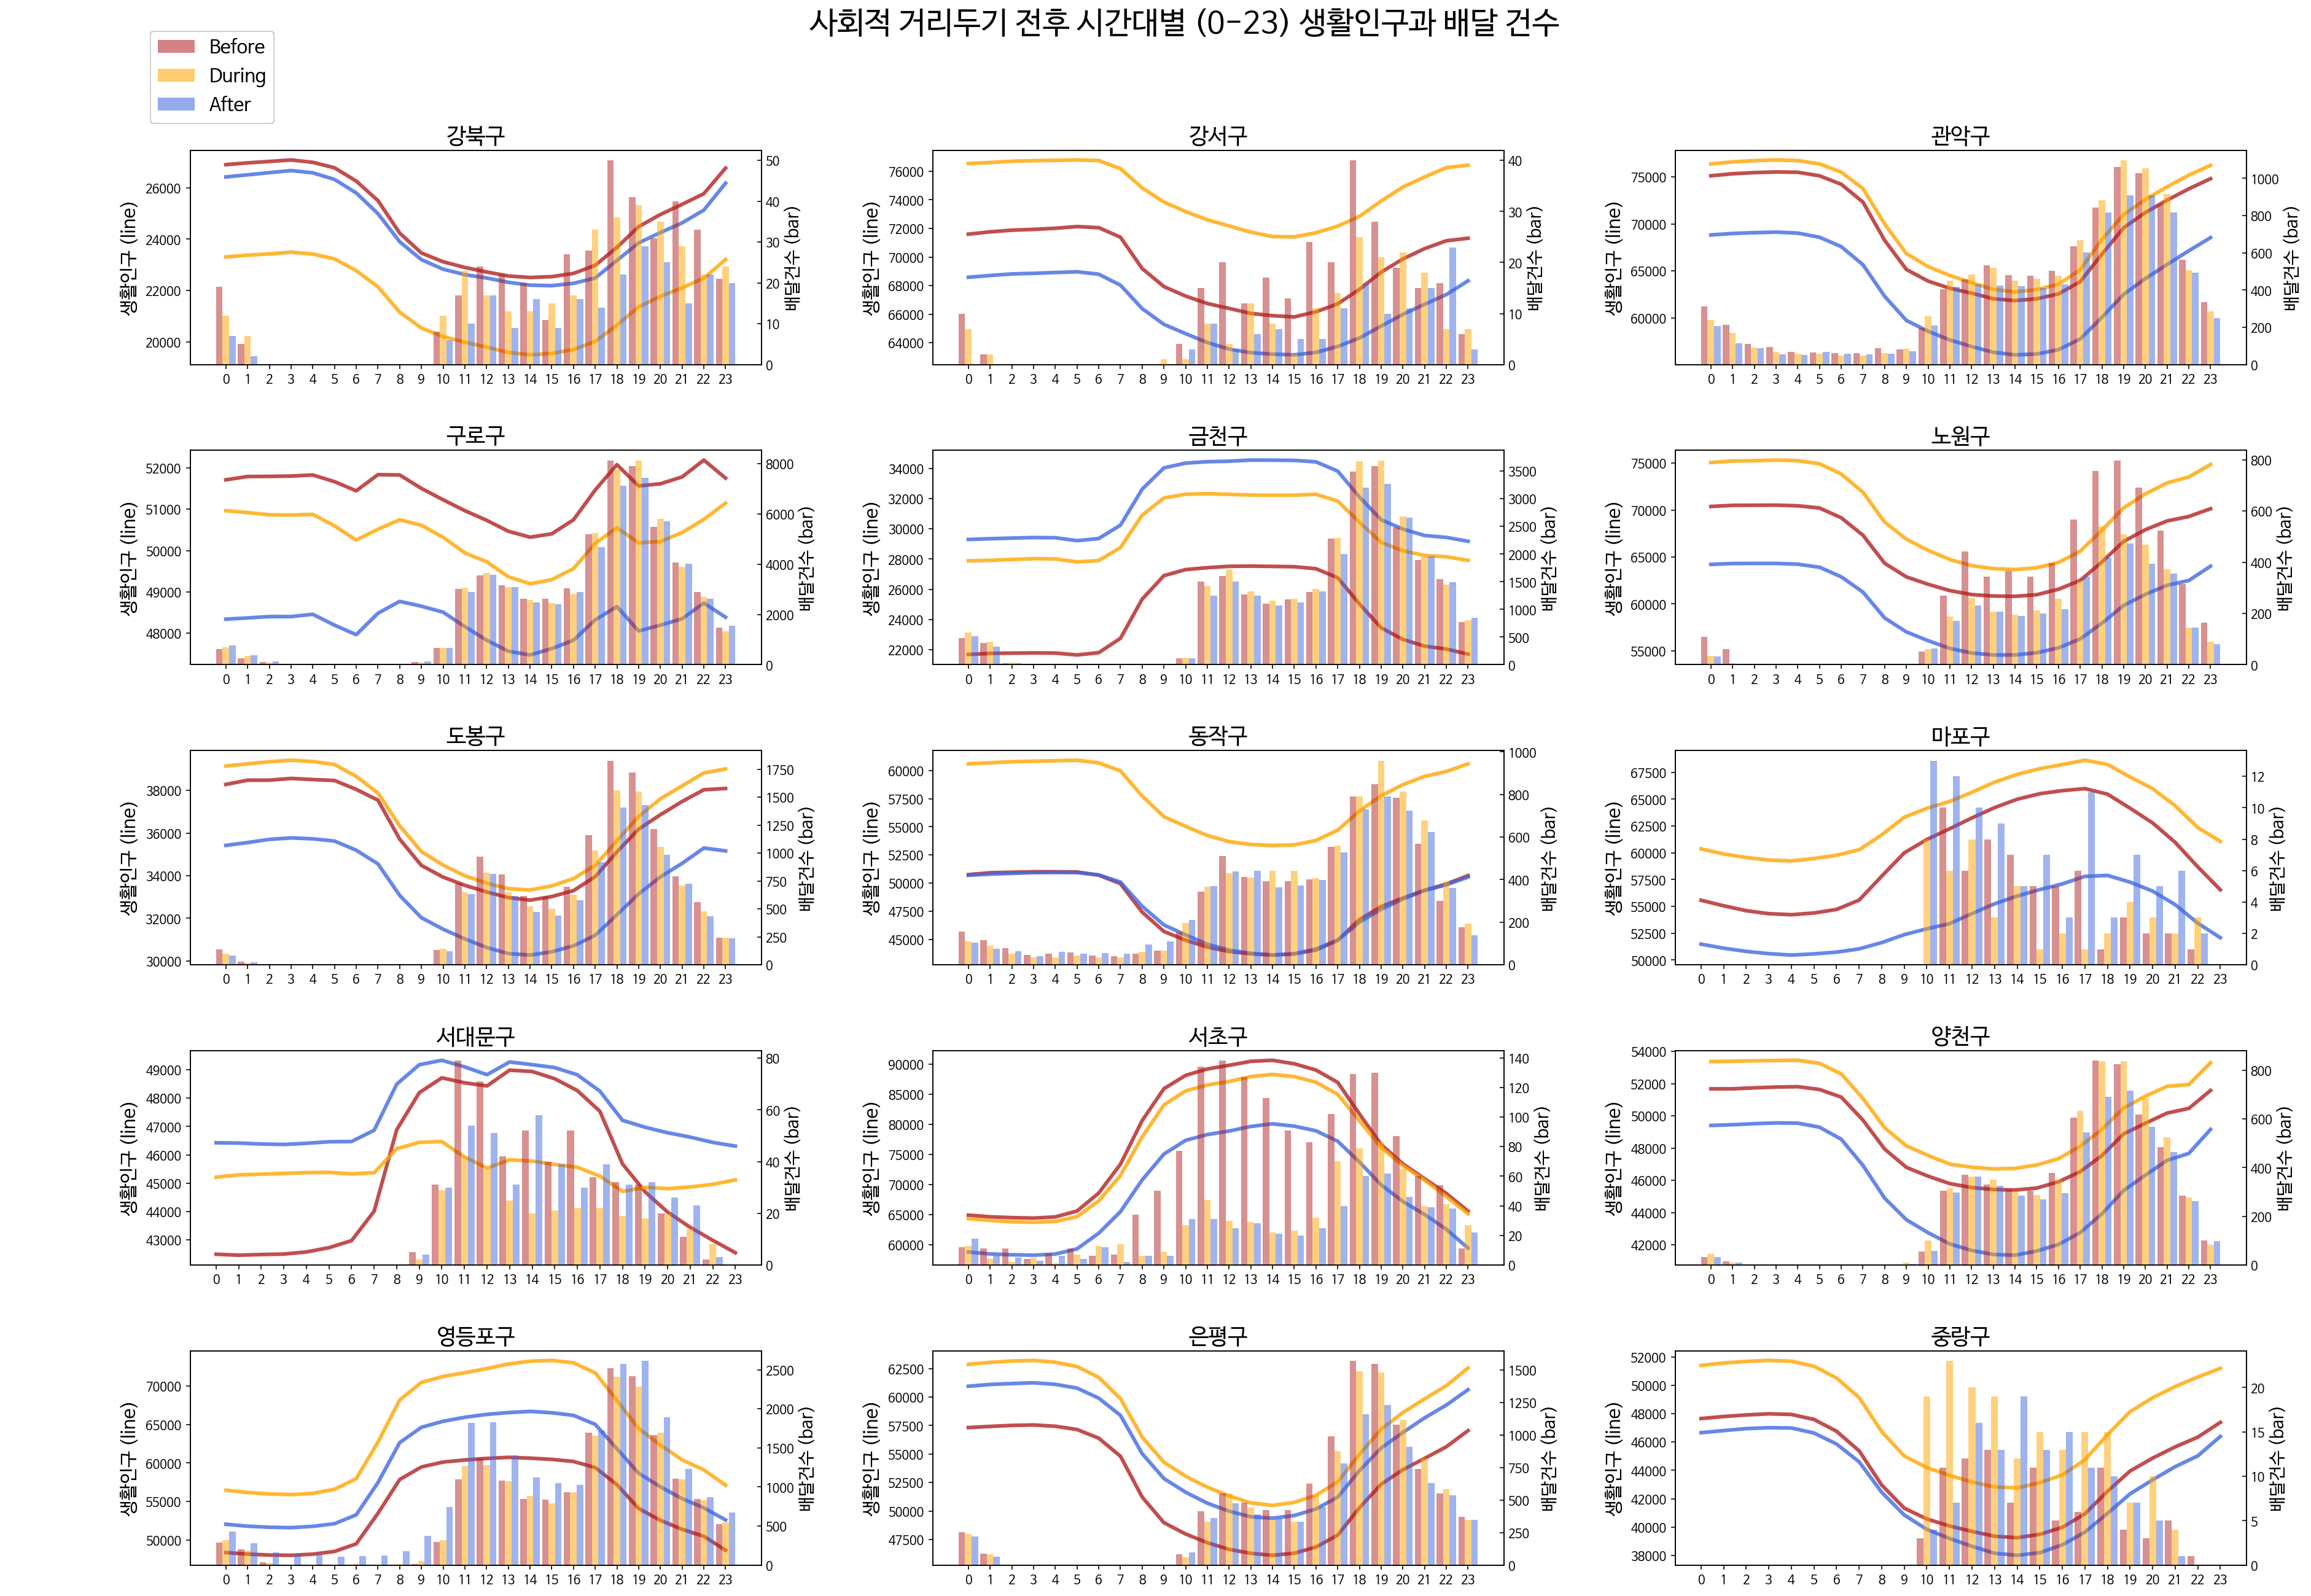

In [ ]:
# 시각화 
fig = plt.figure(figsize = (30, 20))
n = 1

gu_names = ['강북구', '강서구', '관악구', '구로구', '금천구', 
            '노원구', '도봉구', '동작구', '마포구', '서대문구', 
            '서초구', '양천구', '영등포구', '은평구', '중랑구']

for gu_name in gu_names:
  df2 = make_tidy_deliv(gu_name) 
  df1 = make_tidy_pop(gu_name)
  
  ax1 = plt.subplot(5, 3, n)
  ax1.set_title(f'{gu_name}', fontsize = 18) ## subplot 1개의 제목 
  ax1.plot(df1['Hour'],df1['Before'],color='firebrick', markersize=7, linewidth=3, alpha=0.8,label='Before') ## 선그래프 생성
  ax1.plot(df1['Hour'],df1['During'],color='orange', markersize=7, linewidth=3, alpha=0.8,label='During') 
  ax1.plot(df1['Hour'],df1['After'],color='royalblue', markersize=7, linewidth=3, alpha=0.8,label='After')
  ax1.set_ylabel('생활인구 (line)', fontsize = 15)

  ax2 = ax1.twinx()  
  bar_width = 0.3
  ax2.bar(df2['Hour'] - bar_width, df2['Before'], color='firebrick', label='배달건수', alpha=0.5, width=0.3) ## 막대그래프 생성 
  ax2.bar(df2['Hour'], df2['During'], color='orange', label='배달건수', alpha=0.5, width=0.3)
  ax2.bar(df2['Hour'] + bar_width, df2['After'], color='royalblue', label='배달건수', alpha=0.5, width=0.3)
  ax2.set_ylabel('배달건수 (bar)', fontsize = 14)
  ax2.tick_params(axis='y', direction='in')

  ax2.set_xticks([h for h in range(24)]) ## x축 눈금 
  plt.suptitle('사회적 거리두기 전후 시간대별 (0-23) 생활인구과 배달 건수', fontsize = 25) ## 전체 제목
  lines, labels = fig.axes[-1].get_legend_handles_labels() ## 범례
  fig.legend(lines, ['Before', 'During', 'After'], fontsize = 15, loc="upper center", bbox_to_anchor=(0.08, 0.89)) ## 범례

  n += 1

  df1 = pd.DataFrame()
  df2 = pd.DataFrame()

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.3, hspace=0.4) ## subplots 간격 
plt.show()

[ 시각화 해석방법 ] 
* 빨강, 노랑, 파랑 : 사회적 거리두기 이전 & 동안 & 이후
* X 축 : 시간대 (0-23시) 
* Y 축 : 시간대별 생활인구 및 배달 건수
  - 선 그래프 : 생활인구 (line) 
  - 막대 그래프 : 배달 건수 (bar) 

## [ Insight ] 
* **사회적 거리두기 정책의 효과** 
  - 사회적 거리두기 정책은 기본적으로 생활인구의 유동성을 낮춰, 코로나19의 전염성을 줄이고자 하는 정책이므로 생활인구의 시간대별 차이가 적을수록 정책의 효과가 보였다고 할 수 있다. 
* **거주지 vs 상업지**
  - 생활인구 (선그래프) 시각화를 기준으로 판단한다. 
  - 해당 지역구에 거주하는 인구로 추정되는 새벽 시간대의 생활인구에 비해서, 낮 시간대의 생활인구가 적다면 그 지역구는 `거주지` 위주의 지역이라 추측할 수 있다 (∪ 모양). 그 반대라면 `상업지`라 할 수 있다 (∩ 모양). 
  - `거주지`는 주민들이 주로 거주를 목적으로 생활하는 지역이고, `상업지`는 주민들이 주로 경제활동을 목적으로 생활하는 지역이다. 
     - `거주지` (∪) : 강북, 강서, 관악, 노원, 도봉, 동작, 양천, **은평**, 중랑 
     - `상업지` (∩) : 금천, 마포, 서대문, **서초**, 영등포 
* **새벽에도 배달을 시키는 20대?!**
  - 15개 지역구 중 대부분은 새벽 3-6시 동안에는 배달을 거의 시키지 않았으나, 단 3개의 지역구에서는 배달을 시키는 것으로 나타났다 (세 기간 모두에서).
    - 관악구, 동작구, 서초구 
  - 관악구와 동작구에서는 새벽 3-6시 동안 
    - 연령대별 생활인구를 보면 (본론 4.1), 관악구와 동작구에서는 늘 20대가 압도적으로 1위를 차지했다.  

## **4.1 연령대별 생활인구** 
* 사용한 데이터 
  - `popl.csv` (행정동별 생활인구 데이터)
  - `행정동코드_매핑정보_2018.csv` (시군구 및 행정동 코드 데이터; 외부)

In [ ]:
# 시계열 시각화하는 함수 정의 
def time_viz(x, y, data, hue, hue_order, palette, title):
  fig = plt.subplots(figsize = (20, 5))
  sns.lineplot(x = x, y = y, data = data,
              hue = hue, hue_order = hue_order, 
              palette = palette)
  plt.legend(fontsize = 13)
  plt.title(title, fontsize = 18)

In [ ]:
age_grp_list = ['10s', '20s', '30s', '40s', '50s', '60s', '70+']

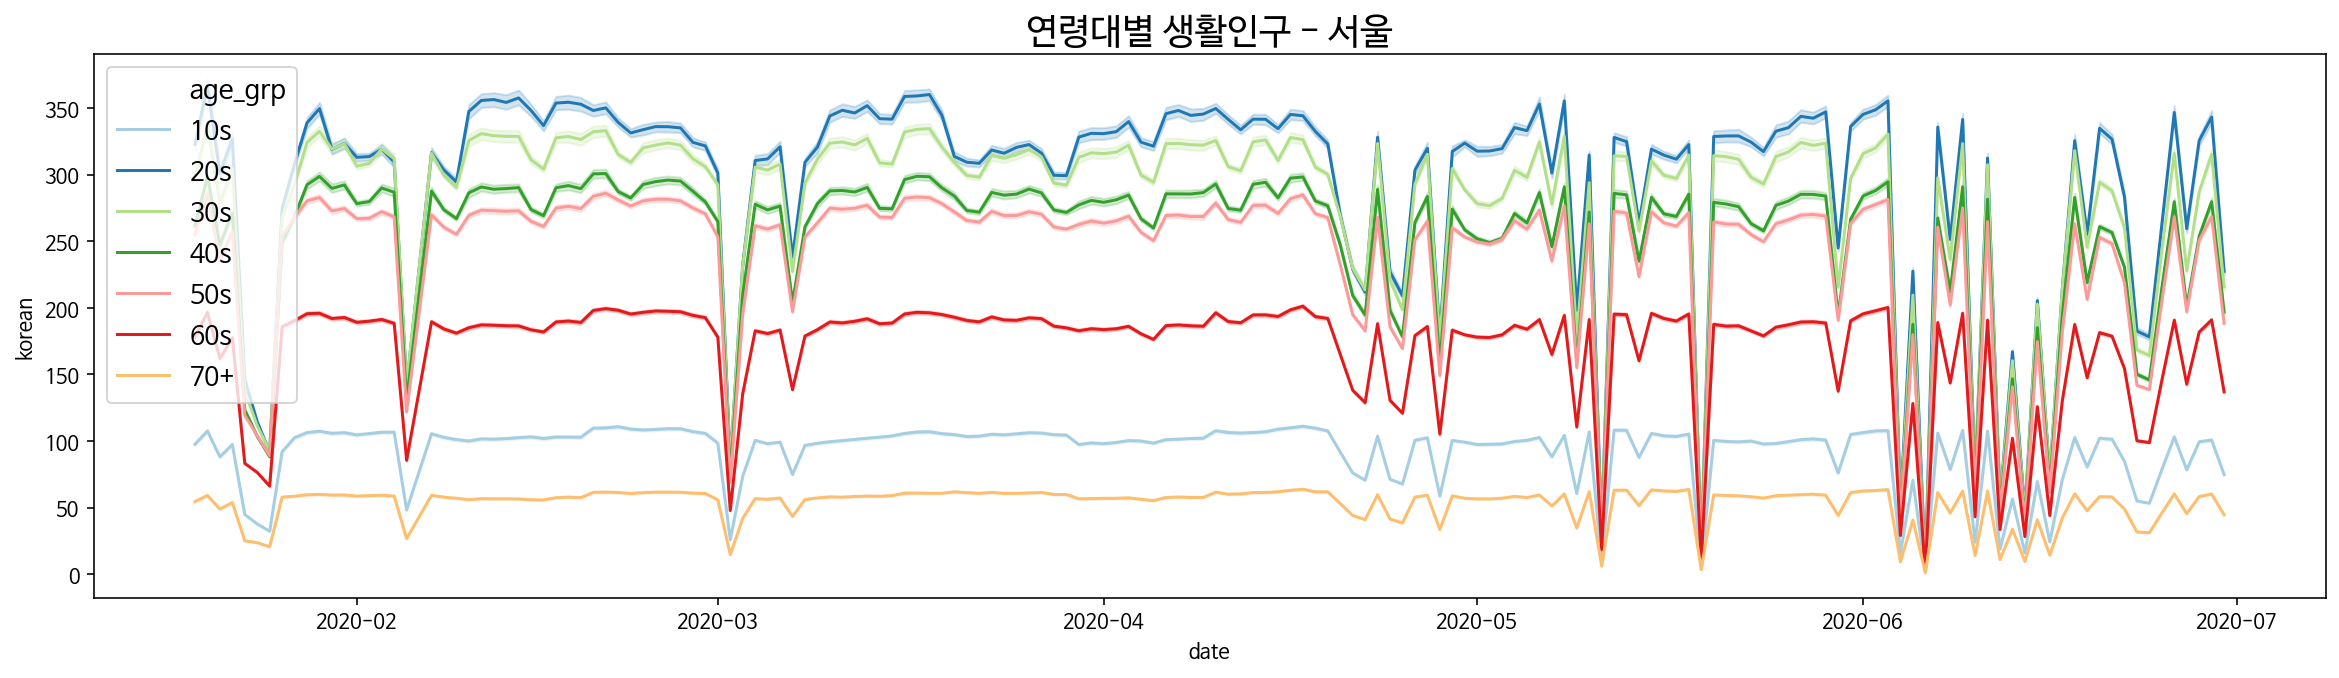

In [ ]:
# 서울 전체 
time_viz('date', 'korean', pop, 'age_grp', age_grp_list, 'Paired', '연령대별 생활인구 - 서울')

###  서울시 구별 연령대 분포 비교

In [ ]:
# 1) 생활인구데이터에서 필요 칼럼만 추출
popl=pop[['date','hour','gender','age_grp','sigungu','ad_dong','korean']]

In [ ]:
# 2) 구별, 연령대별 생활인구 총합 
popl_age=popl.groupby(['sigungu','age_grp'])['korean'].sum().to_frame().reset_index()

In [ ]:
# 3) pivot table로 연령대별 재정렬
pp_age=pd.pivot_table(popl_age,index='sigungu',columns='age_grp',values='korean')
pp_age.reset_index(inplace=True)

In [ ]:
# 4) 구별 생활인구 총합 구하기
popl_age_all=popl_age.groupby('sigungu')['korean'].sum().to_frame().reset_index()

In [ ]:
# 5) 각 연령대별 인구 비율 구하기

# 2번과 4번 merge
pop_age_data=pd.merge(pp_age,popl_age_all, on='sigungu',how='inner')

# 각 연령대별 인구 비율 칼럼 생성
pop_age_data['10_ratio']=(pop_age_data['10s']/pop_age_data['korean'])*100
pop_age_data['20_ratio']=(pop_age_data['20s']/pop_age_data['korean'])*100
pop_age_data['30_ratio']=(pop_age_data['30s']/pop_age_data['korean'])*100
pop_age_data['40_ratio']=(pop_age_data['40s']/pop_age_data['korean'])*100
pop_age_data['50_ratio']=(pop_age_data['50s']/pop_age_data['korean'])*100
pop_age_data['60_ratio']=(pop_age_data['60s']/pop_age_data['korean'])*100
pop_age_data['70+_ratio']=(pop_age_data['70+']/pop_age_data['korean'])*100

In [ ]:
pop_age_ratio=pop_age_data[['sigungu','10_ratio','20_ratio','30_ratio','40_ratio','50_ratio','60_ratio','70+_ratio']]
pop_age_ratio['2-30 ratio']=pop_age_ratio['20_ratio']+pop_age_ratio['30_ratio']
pop_age_ratio['4-50 ratio']=pop_age_ratio['40_ratio']+pop_age_ratio['50_ratio']
age_ratio=pop_age_ratio[['sigungu','2-30 ratio','4-50 ratio']]
age_ratio

sigungu  2-30 ratio  4-50 ratio
0      강남구   44.677166   34.704411
1      강동구   34.857493   36.816680
2      강북구   33.462817   36.444326
3      강서구   41.170115   34.255004
4      관악구   50.482791   28.472256
5      광진구   44.190586   32.929444
6      구로구   39.350495   36.092821
7      금천구   42.448694   35.869351
8      노원구   34.011103   36.464584
9      도봉구   33.173325   36.651640
10    동대문구   41.328681   33.093860
11     동작구   44.592095   31.432782
12     마포구   48.196828   32.284288
13    서대문구   44.012916   33.254161
14     서초구   40.554404   36.922745
15     성동구   43.256040   34.250559
16     성북구   38.961491   34.224226
17     송파구   39.294116   35.876708
18     양천구   32.792391   38.340523
19    영등포구   44.144595   35.175226
20     용산구   44.583280   35.143103
21     은평구   35.661235   36.191180
22     종로구   41.869045   36.622402
23      중구   44.422722   37.676866
24     중랑구   35.829434   36.573852

In [ ]:
# 2-30대 비율 높은 구 top 5
age_ratio.sort_values(by='2-30 ratio', ascending=False).head(5)

sigungu  2-30 ratio  4-50 ratio
4      관악구   50.482791   28.472256
12     마포구   48.196828   32.284288
0      강남구   44.677166   34.704411
11     동작구   44.592095   31.432782
20     용산구   44.583280   35.143103

* 관악구는 2-30대 비율이 가장 높다.

In [ ]:
# 4-50대 비율 높은 구 top5
age_ratio.sort_values(by='4-50 ratio',ascending=False).head(5)

sigungu  2-30 ratio  4-50 ratio
18     양천구   32.792391   38.340523
23      중구   44.422722   37.676866
14     서초구   40.554404   36.922745
1      강동구   34.857493   36.816680
9      도봉구   33.173325   36.651640

* 전기간에 걸쳐 날짜별로 생활인구는 오르락 내리락하지만, 연령대별로 생활인구가 많은 순서는 크게 변하지 않는다. 
  - 늘 20대 > 30대 > 40대 > 50대의 순위가 유지되었다. 
* 하지만, 지역구별로 살펴보면 연령대별 생활인구 패턴이 다를 수 있기 때문에 4개의 지역구(아래)를 선택하여 더 자세히 살펴보았다. 
  - 관악구 : 20-30대의 생활인구가 많은 지역구 
  - 도봉구 : 40-50대 생활인구가 많은 지역구
  - 은평구 : 본론4에서 `거주지`로 판단한 지역구, 2-30대와 4-50대 생활인구 비율 비슷
  - 서초구 : 본론4에서 `상업지`로 판단한 지역구, 2-30대와 4-50대 생활인구 비율 비슷

### 관악구 
* 전기간에 걸쳐 **20대 생활인구가 압도적으로 제일 많다** (짙은 파란색). 
   - 20대는 서울 전체에서 늘 1위이긴 했으나, 관악구는 압도적으로 1위였다는 점에서 20대가 유난히 많은 지역구라고 할 수 있다. 

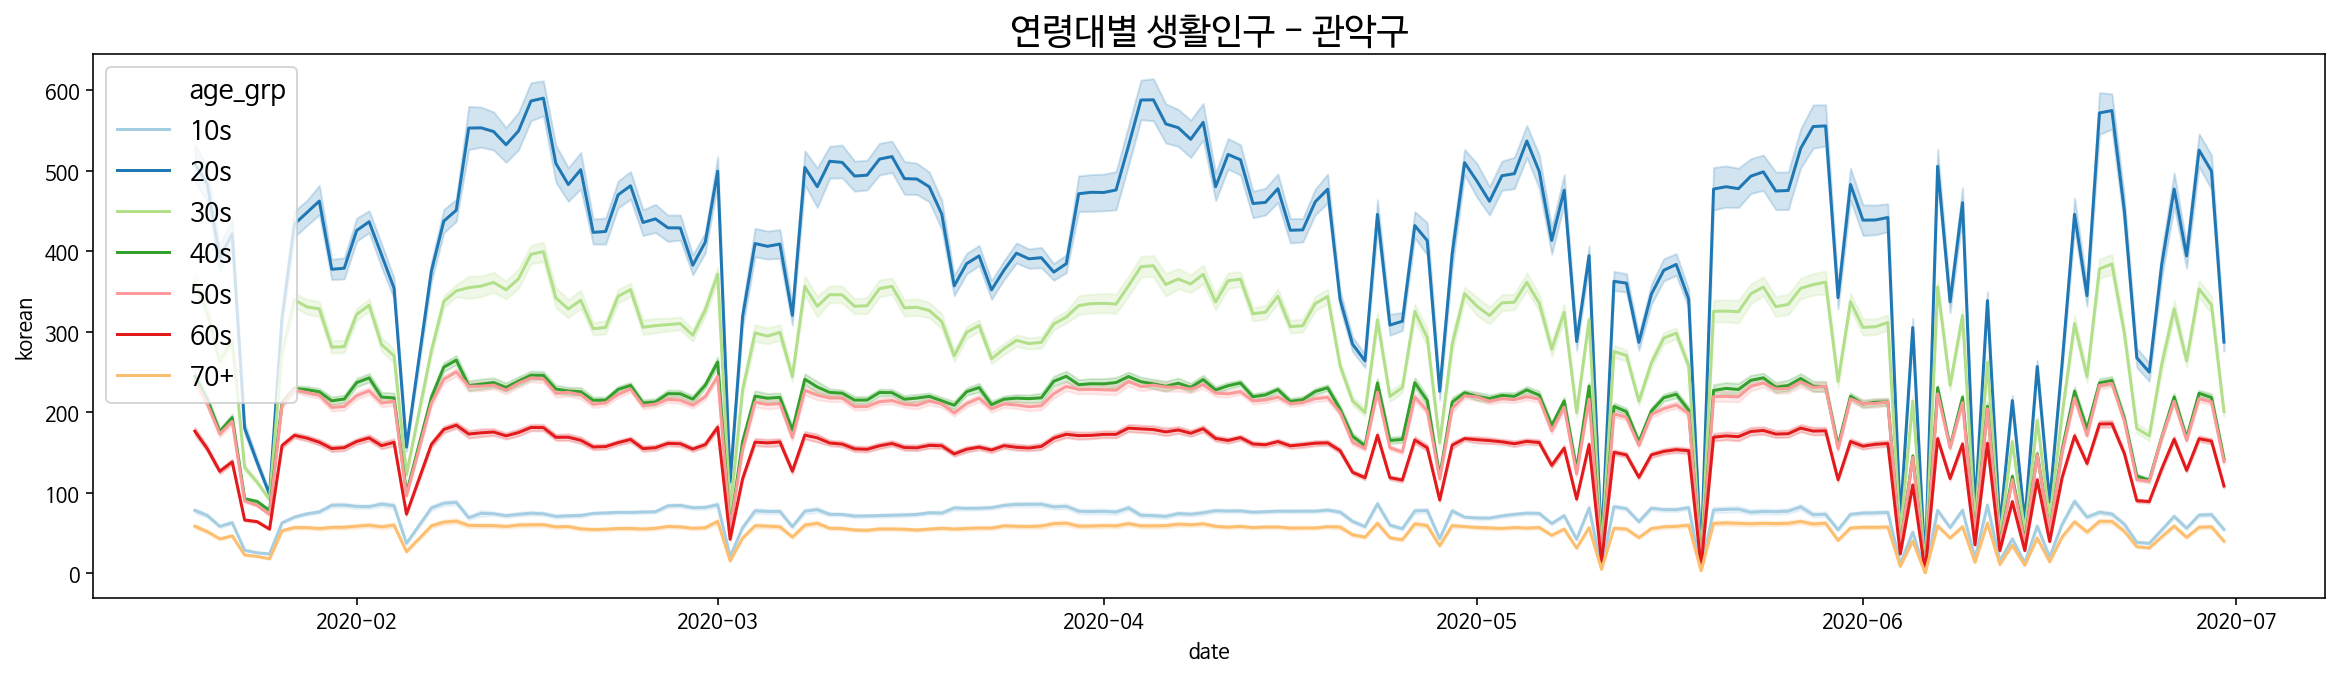

In [ ]:
# 관악구 
df = pop[(pop['sigungu'] == '관악구')]
time_viz('date', 'korean', df, 'age_grp', age_grp_list, 'Paired', '연령대별 생활인구 - 관악구')

관악구 시간대별 배달업종별 배달건수

In [ ]:
# 배달호출데이터 도착지 기준 관악구만 추출
deliv_ga=deliv[(deliv['dest_sigungu']=='관악구')]

In [ ]:
deliv_ga.set_index(deliv_ga['deliv_order_time'], inplace = True)
deliv_ga_hour=pd.DataFrame(deliv_ga.resample('1H')['str_ind'].value_counts())
deliv_ga_hour.rename(columns={'str_ind':'deliv_count'},inplace=True)
deliv_ga_hour.reset_index(inplace=True)
deliv_ga_hour['order_hour']=deliv_ga_hour['deliv_order_time'].dt.hour
deliv_ga_hour.head()

deliv_order_time str_ind  deliv_count  order_hour
0 2019-12-01 18:00:00  카페/디저트            9          18
1 2019-12-01 18:00:00      치킨            3          18
2 2019-12-01 18:00:00      피자            2          18
3 2019-12-01 18:00:00   족발/보쌈            1          18
4 2019-12-01 18:00:00      중식            1          18

In [ ]:
ga_hour_count=deliv_ga_hour.groupby(['order_hour','str_ind'])['deliv_count'].sum().to_frame().reset_index()
ga_hour_count.head()

order_hour str_ind  deliv_count
0           0      분식           20
1           0      야식           34
2           0   족발/보쌈           35
3           0      중식           13
4           0      치킨          937

In [ ]:
ga_hour_order = px.line(ga_hour_count, x='order_hour', y='deliv_count', color='str_ind',title='관악구(도착지) 시간대별 업종별 배달건수')
pyo.iplot(ga_hour_order )

* 시간대별 차이는 있으나 카페/디저트가 압도적으로 배달건수가 높고 치킨, 패스트푸드가 그 뒤를 이었다. 

### 도봉구
* 전기간에 걸쳐 **50대 생활인구가 제일 많다** (분홍색) 
   - 50대가 압도적으로 제일 많은 것은 아니나, 서울 전체에서는 50대가 늘 4위였던 것을 고려하면, 도봉구는 50대가 많은 지역구라고 할 수 있다. 

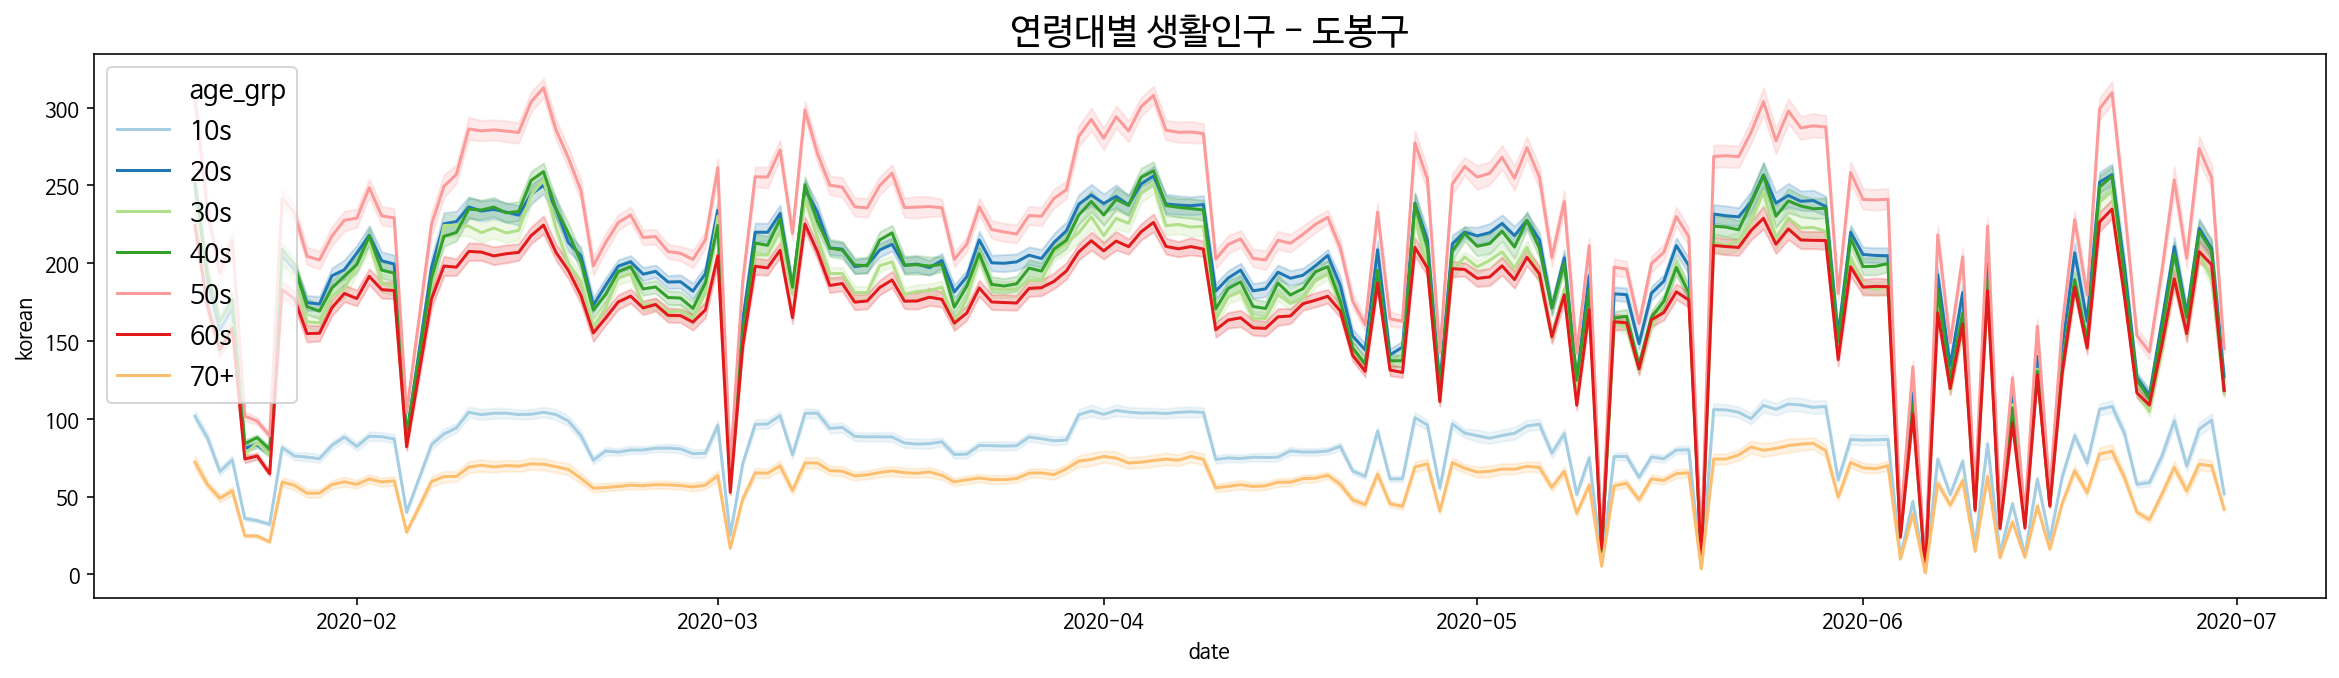

In [ ]:
# 도봉구 
df = pop[(pop['sigungu'] == '도봉구')]
time_viz('date', 'korean', df, 'age_grp', age_grp_list, 'Paired', '연령대별 생활인구 - 도봉구')

도봉구 시간대별 배달업종별 배달건수

In [ ]:
# 배달호출데이터 도착지 기준 도봉구만 추출
deliv_db=deliv[(deliv['dest_sigungu']=='도봉구')]

In [ ]:
deliv_db.set_index(deliv_db['deliv_order_time'], inplace = True)
deliv_db_hour=pd.DataFrame(deliv_db.resample('1H')['str_ind'].value_counts())
deliv_db_hour.rename(columns={'str_ind':'deliv_count'},inplace=True)
deliv_db_hour.reset_index(inplace=True)
deliv_db_hour['order_hour']=deliv_db_hour['deliv_order_time'].dt.hour
deliv_db_hour.head()

deliv_order_time str_ind  deliv_count  order_hour
0 2019-12-01 18:00:00      분식            7          18
1 2019-12-01 18:00:00      치킨            7          18
2 2019-12-01 18:00:00      피자            7          18
3 2019-12-01 18:00:00  돈까스/일식            4          18
4 2019-12-01 18:00:00   족발/보쌈            4          18

In [ ]:
db_hour_count=deliv_db_hour.groupby(['order_hour','str_ind'])['deliv_count'].sum().to_frame().reset_index()
db_hour_count.head()

order_hour str_ind  deliv_count
0           0      분식            6
1           0  아시안/양식           13
2           0      야식           91
3           0   족발/보쌈           70
4           0      찜탕            5

In [ ]:
db_hour_order = px.line(db_hour_count, x='order_hour', y='deliv_count', color='str_ind',title='도봉구(도착지) 시간대별 업종별 배달건수')
pyo.iplot(db_hour_order)

* 시간대별 차이는 있으나 피자가 제일 배달건수가 높고 족발/보쌈, 한식이 그 뒤를 이었다. 

### 은평구
* 생략 가능 (은평구는 연령대가 포인트가 아니고, 거주지인 게 포인트이므로)
* 서울 전체로 보면 1-4위가 20, 30, 40, 50대 순서인데, 은평구는 20-50대의 비율이 크게 다르지 않다. 

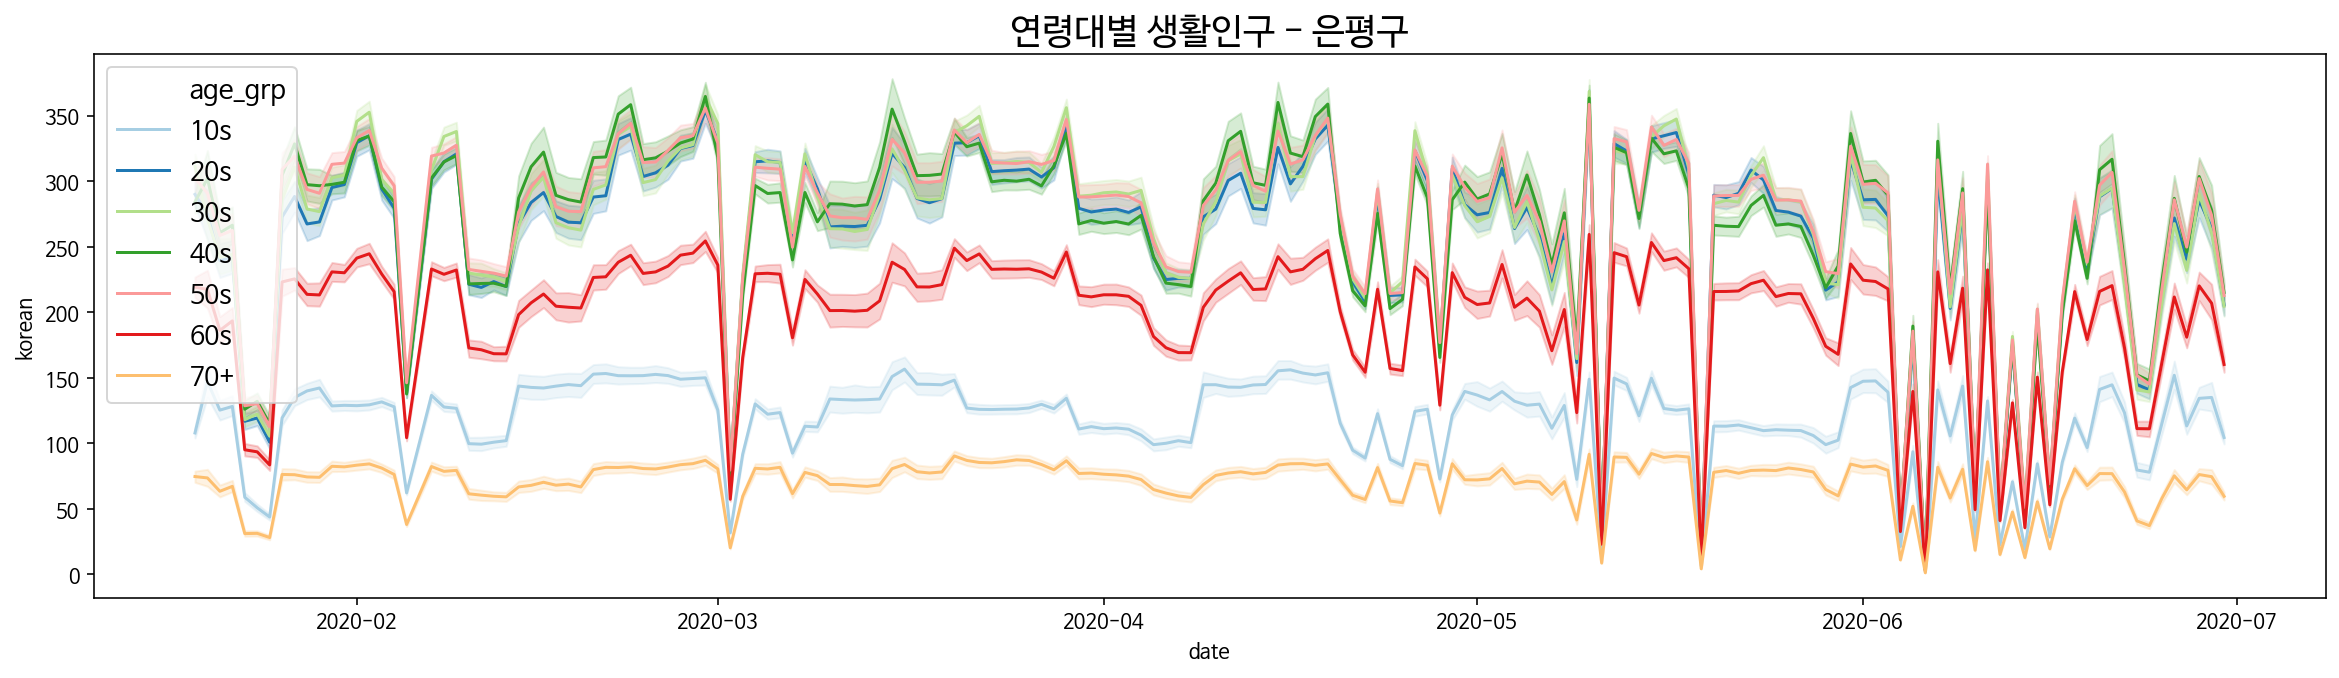

In [ ]:
# 은평구 
df = pop[(pop['sigungu'] == '은평구')]
time_viz('date', 'korean', df, 'age_grp', age_grp_list, 'Paired', '연령대별 생활인구 - 은평구')

은평구 시간대별 배달업종별 배달건수

In [ ]:
deliv_ep=deliv[deliv['dest_sigungu']=='은평구']

In [ ]:
# 배달호출데이터 도착지 기준 은평구만 추출
deliv_ep.set_index(deliv_ep['deliv_order_time'], inplace = True)
deliv_ep_hour=pd.DataFrame(deliv_ep.resample('1H')['str_ind'].value_counts())
deliv_ep_hour.rename(columns={'str_ind':'deliv_count'},inplace=True)
deliv_ep_hour.reset_index(inplace=True)
deliv_ep_hour['order_hour']=deliv_ep_hour['deliv_order_time'].dt.hour
deliv_ep_hour.head()

deliv_order_time str_ind  deliv_count  order_hour
0 2019-12-01 18:00:00   족발/보쌈           11          18
1 2019-12-01 18:00:00  돈까스/일식            6          18
2 2019-12-01 18:00:00      분식            5          18
3 2019-12-01 18:00:00      치킨            5          18
4 2019-12-01 18:00:00      한식            1          18

In [ ]:
ep_hour_count=deliv_ep_hour.groupby(['order_hour','str_ind'])['deliv_count'].sum().to_frame().reset_index()
ep_hour_count.head()

order_hour str_ind  deliv_count
0           0  돈까스/일식           46
1           0      분식          136
2           0   족발/보쌈          292
3           0      치킨          731
4           0      한식           29

In [ ]:
ep_hour_order = px.line(ep_hour_count, x='order_hour', y='deliv_count', color='str_ind',title='은평구(도착지) 시간대별 업종별 배달횟수')
pyo.iplot(ep_hour_order)

* 시간대별 차이는 있으나 치킨이 제일 배달건수가 높고 족발/보쌈, 돈까스/일식이 그 뒤를 이었다. 

### 서초구  
* 생략 가능 (은평구와 같은 이유)
* 은평구만큼은 아니어도, 서초구 또한 20-40대의 비율이 비슷하며 4위인 50대 또한 3위인 20대와 차이가 크지는 않다. 

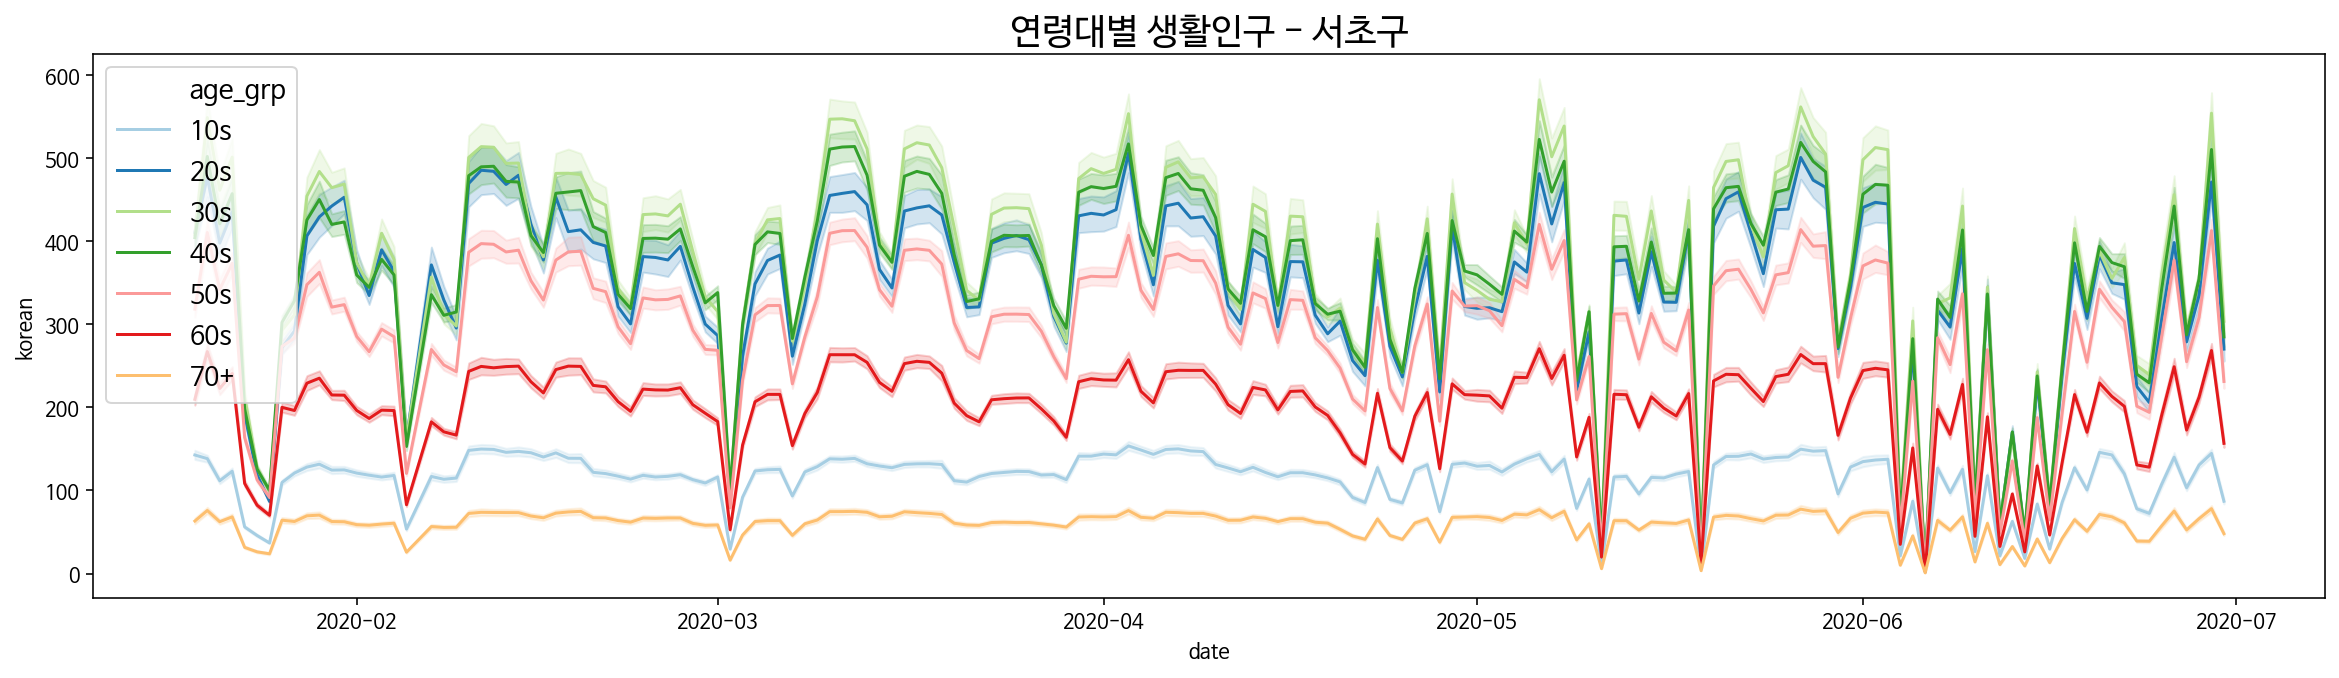

In [ ]:
# 서초구 
df = pop[(pop['sigungu'] == '서초구')]
time_viz('date', 'korean', df, 'age_grp', age_grp_list, 'Paired', '연령대별 생활인구 - 서초구')

서초구 시간대별 배달업종별 배달건수

In [ ]:
# 배달호출데이터 도착지 기준 서초구만 추출
deliv_sc=deliv[deliv['dest_sigungu']=='서초구']

In [ ]:
deliv_sc.set_index(deliv_sc['deliv_order_time'], inplace = True)
deliv_sc_hour=pd.DataFrame(deliv_sc.resample('1H')['str_ind'].value_counts())
deliv_sc_hour.rename(columns={'str_ind':'deliv_count'},inplace=True)
deliv_sc_hour.reset_index(inplace=True)
deliv_sc_hour['order_hour']=deliv_sc_hour['deliv_order_time'].dt.hour
deliv_sc_hour.head()

deliv_order_time str_ind  deliv_count  order_hour
0 2019-12-01 18:00:00      치킨            2          18
1 2019-12-01 18:00:00   족발/보쌈            1          18
2 2019-12-01 19:00:00      치킨            6          19
3 2019-12-01 20:00:00      치킨            1          20
4 2019-12-01 20:00:00      피자            1          20

In [ ]:
sc_hour_count=deliv_sc_hour.groupby(['order_hour','str_ind'])['deliv_count'].sum().to_frame().reset_index()
sc_hour_count.head()

order_hour str_ind  deliv_count
0           0      치킨           93
1           0   패스트푸드           57
2           0      피자           10
3           1      치킨           50
4           1   패스트푸드           64

In [ ]:
sc_hour_order = px.line(sc_hour_count, x='order_hour', y='deliv_count', color='str_ind',title='서초구(도착지) 시간대별 업종별 배달횟수')
pyo.iplot(sc_hour_order)

* 시간대별 차이는 있으나 치킨이 제일 배달건수가 높고 패스트푸드, 피자가 그 뒤를 이었다. 

## __본론5. 날씨, 코로나, 요일이 배달건수에 영향을 주는가__

날씨(기온, 강수량, 풍향, 풍속, 상대습도), 코로나 확진자, 배달접수 요일이 배달건수에 영향을 주는지 배달건수를 타겟변수로 해 XGB 모델로 훈련시켰다.

### 1) 모델링 데이터셋 생성

In [ ]:
# 일별 업종별 배달건수 데이터셋
dlvr=deliv[(deliv['month']!=12)& (deliv['str_sido']=='서울특별시')]
dlvr.set_index(dlvr['deliv_order_time'],inplace=True)
dlvr_day_count=pd.DataFrame(dlvr.resample('1D')['str_ind'].value_counts())
dlvr_day_count.rename(columns={'str_ind':'deliv_count'},inplace=True)
dlvr_day_count.reset_index(inplace=True)
dlvr_day_count['dow']=dlvr_day_count['deliv_order_time'].dt.weekday+1
dlvr_day_count.columns=['date','str_ind','배달건수','요일']
dlvr_day_count.head()

date str_ind  배달건수  요일
0 2020-01-01      치킨  1503   3
1 2020-01-01      분식   717   3
2 2020-01-01  카페/디저트   625   3
3 2020-01-01      한식   446   3
4 2020-01-01   패스트푸드   437   3

In [ ]:
df=dlvr_day_count.groupby('date')['배달건수'].sum().reset_index()
df['dow']=df['date'].dt.weekday+1
df.columns=['date','배달건수','요일']

# 배달데이터와 날씨데이터 결합
weather_deliv=pd.merge(all_wea,df,left_on='date',right_on='date',how='inner')

In [ ]:
# 코로나 일별 확진자수 데이터
time_new=time.groupby(['date'])['new'].sum().reset_index()

In [ ]:
# 데이터셋 생성
wea_co_deliv=pd.merge(time_new,weather_deliv, on='date', how='inner')
wea_co_deliv.rename(columns={'new':'corona_count'},inplace=True)
wea_co_deliv.head()

date  corona_count  avg_temp  min_temp  max_temp  precipitation  \
0 2020-01-20             0       0.7      -3.3       5.5            0.0   
1 2020-01-21             0      -0.4      -5.6       5.5            0.0   
2 2020-01-22             0       3.0      -0.1       7.8            0.0   
3 2020-01-23             0       4.6       0.0       9.9            0.0   
4 2020-01-24             1       2.8      -1.3       7.4            0.0   

   max_wind_speed  most_wind_direction  avg_relative_humidity  배달건수  요일  
0             5.7                270.0                   46.8  3314   1  
1             3.5                320.0                   36.9  3434   2  
2             3.2                 50.0                   36.0  3559   3  
3             4.7                290.0                   49.3  4199   4  
4             3.7                290.0                   63.0  3728   5

### 2) XGBoost Regressor

In [ ]:
# 모델링 관련 라이브러리 호출
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [ ]:
X=wea_co_deliv[['corona_count','avg_temp','min_temp','max_temp','precipitation','max_wind_speed','most_wind_direction','avg_relative_humidity','요일']]
y=wea_co_deliv['배달건수']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)
xgb_reg = xgb.XGBRegressor(n_estimators=500, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=0.75,max_depth=5)
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
pred=xgb_reg.predict(X_test)
r_square=xgb_reg.score(X_train,y_train)
print(r_square)

0.9999999920365301


In [ ]:
mean_absolute_error(y_test,pred)

573.5794361255787

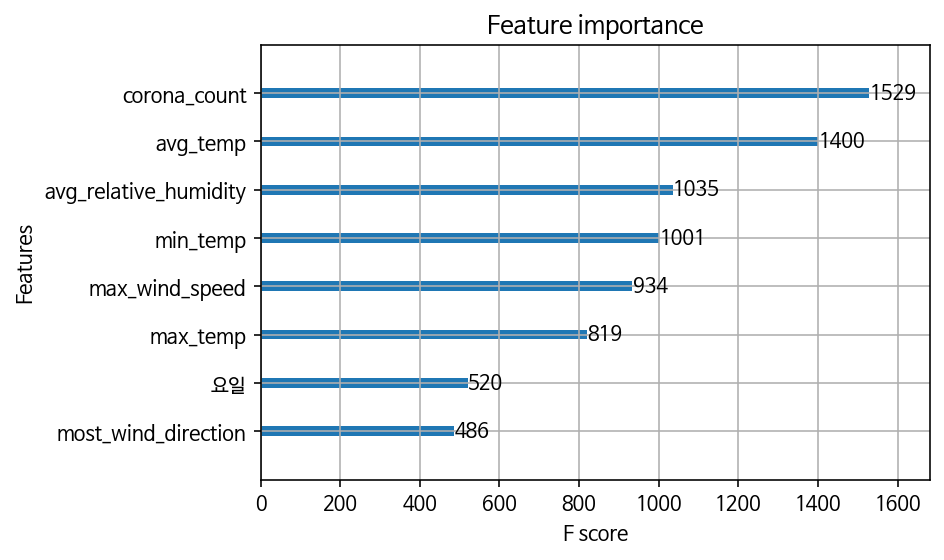

In [ ]:
xgb.plot_importance(xgb_reg)

* feature importance 결과 코로나 확진자수가 배달건수에 가장 큰 영향을 미친다는 것을 알 수 있다.

## __본론6. 분석 결과 및 한계점__

### 분석결과

### 한계점

## __결론__